In [1]:
import h2o
from h2o.automl import H2OAutoML
import random, os, sys
from datetime import datetime
import pandas as pd
import logging
import numpy as np
import csv
import optparse
import time
import json
from distutils.util import strtobool
import psutil
import h2o
from h2o.estimators.gbm import H2OGradientBoostingEstimator
from h2o.estimators.random_forest import H2ORandomForestEstimator
from h2o.estimators.glm import H2OGeneralizedLinearEstimator
from h2o.estimators.deeplearning import H2ODeepLearningEstimator
from h2o.grid.grid_search import H2OGridSearch
import matplotlib.pyplot as plt

In [14]:
data_path=None
all_variables=None
test_path=None
# target='search_term'
target=None
nthreads=1 
min_mem_size=6 
run_time=1000
classification=False
scale=False
max_models=100    
model_path=None
balance_y=False 
balance_threshold=0.2
name=None 
server_path=None  
analysis=0


In [3]:
#Funtion for meta data
def set_meta_data(analysis,run_id,server,data,test,model_path,target,run_time,classification,scale,model,balance,
                  balance_threshold,name,path,nthreads,min_mem_size):
  m_data={}
  m_data['start_time'] = time.time()
  m_data['target']=target
  m_data['server_path']=server
  m_data['data_path']=data 
  m_data['test_path']=test
  m_data['max_models']=model
  m_data['run_time']=run_time
  m_data['run_id'] =run_id
  m_data['scale']=scale
  m_data['classification']=classification
  m_data['scale']=False
  m_data['model_path']=model_path
  m_data['balance']=balance
  m_data['balance_threshold']=balance_threshold
  m_data['project'] =name
  m_data['end_time'] = time.time()
  m_data['execution_time'] = 0.0
  m_data['run_path'] =path
  m_data['nthreads'] = nthreads
  m_data['min_mem_size'] = min_mem_size
  m_data['analysis'] = analysis
 
  return m_data




In [4]:
#Function to convert dictionary into json file
def dict_to_json(dct,n):
  j = json.dumps(dct, indent=4)
  f = open(n, 'w')
  print(j, file=f)
  f.close()
    
#Function for random alphabet   
def alphabet(n):
  alpha='0123456789abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ'    
  str=''
  r=len(alpha)-1   
  while len(str)<n:
    i=random.randint(0,r)
    str+=alpha[i]   
  return str

def impute_missing_values(df, x, scal=False):
    # determine column types
    ints, reals, enums = [], [], []
    for key, val in df.types.items():
        if key in x:
            if val == 'enum':
                enums.append(key)
            elif val == 'int':
                ints.append(key)            
            else: 
                reals.append(key)    
    _ = df[reals].impute(method='mean')
    _ = df[ints].impute(method='median')
    if scal:
        df[reals] = df[reals].scale()
        df[ints] = df[ints].scale()    
    return


    

def predictions(mod,data,run_id):
    test = h2o.import_file(data)
    mod_perf=mod_best.model_performance(test)
              
    stats_test={}
    stats_test=model_performance_stats(mod_perf)

    n=run_id+'_test_stats.json'
    dict_to_json(stats_test,n) 

    try:    
      cf=mod_perf.confusion_matrix(metrics=["f1","f2","f0point5","accuracy","precision","recall","specificity","absolute_mcc","min_per_class_accuracy","mean_per_class_accuracy"])
      cf_df=cf[0].table.as_data_frame()
      cf_df.to_csv(run_id+'_test_confusion_matrix.csv')
    except:
      pass

    predictions = mod_best.predict(test)
    predictions_df=test.cbind(predictions).as_data_frame() 
    predictions_df.to_csv(run_id+'_predictions.csv')
    return
def predictions_test(mod,test,run_id):
    mod_perf=mod_best.model_performance(test)          
    stats_test={}
    stats_test=model_performance_stats(mod_perf)
    n=run_id+'_test_stats.json'
    dict_to_json(stats_test,n) 
    try:
      cf=mod_perf.confusion_matrix()
#      cf=mod_perf.confusion_matrix(metrics=["f1","f2","f0point5","accuracy","precision","recall","specificity","absolute_mcc","min_per_class_accuracy","mean_per_class_accuracy"])
      cf_df=cf.table.as_data_frame()
      cf_df.to_csv(run_id+'_test_confusion_matrix.csv')
    except:
      pass
    predictions = mod_best.predict(test)    
    predictions_df=test.cbind(predictions).as_data_frame() 
    predictions_df.to_csv(run_id+'_predictions.csv')
    return predictions

def check_X(x,df):
    for name in x:
        if name not in df.columns:
          x.remove(name)  
    return x    
    
    
def get_stacked_ensemble(lst):
    se=None
    for model in model_set:
      if 'BestOfFamily' in model:
        se=model
    if se is None:     
      for model in model_set:
        if 'AllModels'in model:
          se=model           
    return se       
    
def get_variables_types(df):
    d={}
    for key, val in df.types.items():
        d[key]=val
    return d    

In [5]:
def se_stats(modl):
    d={}
    d['algo']=modl.algo
    d['model_id']=modl.model_id  
    d['auc']=modl.auc()   
    d['roc']=modl.roc()
    d['mse']=modl.mse()   
    d['null_degrees_of_freedom']=modl.null_degrees_of_freedom()
    d['null_deviance']=modl.null_deviance()
    d['residual_degrees_of_freedom']=modl.residual_degrees_of_freedom()   
    d['residual_deviance']=modl.residual_deviance()
    d['rmse']=modl.rmse()
    return d

def get_model_by_algo(algo,models_dict):
    mod=None
    mod_id=None    
    for m in list(models_dict.keys()):
        if m[0:3]==algo:
            mod_id=m
            mod=h2o.get_model(m)      
    return mod,mod_id     
    
    

In [6]:
def stackedensemble(mod):
    coef_norm=None
    try:
      metalearner = h2o.get_model(mod.metalearner()['name'])
      coef_norm=metalearner.coef_norm()
    except:
      pass        
    return coef_norm

def stackedensemble_df(df):
    bm_algo={ 'GBM': None,'GLM': None,'DRF': None,'XRT': None,'Dee': None}
    for index, row in df.iterrows():
      if len(row['model_id'])>3:
        key=row['model_id'][0:3]
        if key in bm_algo:
          if bm_algo[key] is None:
                bm_algo[key]=row['model_id']
    bm=list(bm_algo.values()) 
    bm=list(filter(None.__ne__, bm))             
    return bm


def gbm_stats(modl):
    d={}
    d['algo']=modl.algo
    d['model_id']=modl.model_id   
    d['varimp']=modl.varimp()  
    return d
    
    
def dl_stats(modl):
    d={}
    d['algo']=modl.algo
    d['model_id']=modl.model_id   
    d['varimp']=modl.varimp()  
    return d
    

In [7]:
def drf_stats(modl):
    d={}
    d['algo']=modl.algo
    d['model_id']=modl.model_id   
    d['varimp']=modl.varimp()  
    d['roc']=modl.roc()     
    return d
    
def xrt_stats(modl):
    d={}
    d['algo']=modl.algo
    d['model_id']=modl.model_id   
    d['varimp']=modl.varimp()  
    d['roc']=modl.roc()      
    return d
    
    
def glm_stats(modl):
    d={}
    d['algo']=modl.algo
    d['model_id']=modl.model_id   
    d['coef']=modl.coef()  
    d['coef_norm']=modl.coef_norm()      
    return d

In [8]:

    
def model_performance_stats(perf):
    d={}
    try:    
      d['mse']=perf.mse()
    except:
      pass      
    try:    
      d['rmse']=perf.rmse() 
    except:
      pass      
    try:    
      d['null_degrees_of_freedom']=perf.null_degrees_of_freedom()
    except:
      pass      
    try:    
      d['residual_degrees_of_freedom']=perf.residual_degrees_of_freedom()
    except:
      pass      
    try:    
      d['residual_deviance']=perf.residual_deviance() 
    except:      pass      
    try:    
      d['null_deviance']=perf.null_deviance() 
    except:
      pass      
    try:    
      d['aic']=perf.aic() 
    except:
      pass      
    try:
      d['logloss']=perf.logloss() 
    except:
      pass    
    try:
      d['auc']=perf.auc()
    except:
      pass  
    try:
      d['gini']=perf.gini()
    except:
      pass    
    return d

In [9]:
all_variables=None

In [21]:
data_path='C:/Users/pkash/Downloads/adult.csv'

In [22]:
run_id=alphabet(9)
if server_path==None:
    server_path=os.path.abspath(os.curdir)
os.chdir(server_path) 
run_dir = os.path.join(server_path,run_id)
os.mkdir(run_dir)
os.chdir(run_dir)    

# run_id to std out
print (run_id)

IpxFGNwiH


In [23]:
##For logs
logfile=run_id+'_autoh2o_log.zip'
logs_path=os.path.join(run_dir,'logs')
print(logs_path,' ',logfile)

C:\Users\pkash\iqhzVWRCU\IpxFGNwiH\logs   IpxFGNwiH_autoh2o_log.zip


In [24]:
h2o.init(ip="localhost", port=54323)

Checking whether there is an H2O instance running at http://localhost:54323 . connected.


H2O cluster uptime:,6 hours 49 mins
H2O cluster timezone:,America/New_York
H2O data parsing timezone:,UTC
H2O cluster version:,3.24.0.1
H2O cluster version age:,19 days
H2O cluster name:,H2O_from_python_pkash_psun55
H2O cluster total nodes:,1
H2O cluster free memory:,739 Mb
H2O cluster total cores:,8
H2O cluster allowed cores:,8
H2O cluster status:,"locked, healthy"


In [25]:
# meta data
meta_data = set_meta_data(analysis, run_id,server_path,data_path,test_path,model_path,target,run_time,classification,scale,max_models,balance_y,balance_threshold,name,run_dir,nthreads,min_mem_size)
print(meta_data)

{'start_time': 1555791682.494615, 'target': None, 'server_path': 'C:\\Users\\pkash\\iqhzVWRCU', 'data_path': 'C:/Users/pkash/Downloads/adult.csv', 'test_path': None, 'max_models': 100, 'run_time': 1000, 'run_id': 'IpxFGNwiH', 'scale': False, 'classification': False, 'model_path': None, 'balance': False, 'balance_threshold': 0.2, 'project': None, 'end_time': 1555791682.494615, 'execution_time': 0.0, 'run_path': 'C:\\Users\\pkash\\iqhzVWRCU\\IpxFGNwiH', 'nthreads': 1, 'min_mem_size': 6, 'analysis': 0}


In [26]:
df = h2o.import_file(data_path)

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [28]:
df.head()

age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K
38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K
28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K
44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K
18,?,103497,Some-college,10,Never-married,?,Own-child,White,Female,0,0,30,United-States,<=50K
34,Private,198693,10th,6,Never-married,Other-service,Not-in-family,White,Male,0,0,30,United-States,<=50K
29,?,227026,HS-grad,9,Never-married,?,Unmarried,Black,Male,0,0,40,United-States,<=50K
63,Self-emp-not-inc,104626,Prof-school,15,Married-civ-spouse,Prof-specialty,Husband,White,Male,3103,0,32,United-States,>50K
24,Private,369667,Some-college,10,Never-married,Other-service,Unmarried,White,Female,0,0,40,United-States,<=50K
55,Private,104996,7th-8th,4,Married-civ-spouse,Craft-repair,Husband,White,Male,0,0,10,United-States,<=50K


In [29]:

df.describe()
# shows that there is no missing values in the data

Rows:48842
Cols:15




,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
type,int,enum,int,enum,int,enum,enum,enum,enum,enum,int,int,int,enum,enum
mins,17.0,,12285.0,,1.0,,,,,,0.0,0.0,1.0,,
mean,38.643585438761704,,189664.13459727284,,10.078088530363212,,,,,,1079.0676262233324,87.50231358257237,40.42238237582409,,
maxs,90.0,,1490400.0,,16.0,,,,,,99999.0,4356.0,99.0,,
sigma,13.710509934443555,,105604.02542315728,,2.570972755592256,,,,,,7452.019057655393,403.00455212435907,12.391444024252307,,
zeros,0,,0,,0,,,,,,44807,46560,0,,
missing,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
0,25.0,Private,226802.0,11th,7.0,Never-married,Machine-op-inspct,Own-child,Black,Male,0.0,0.0,40.0,United-States,<=50K
1,38.0,Private,89814.0,HS-grad,9.0,Married-civ-spouse,Farming-fishing,Husband,White,Male,0.0,0.0,50.0,United-States,<=50K
2,28.0,Local-gov,336951.0,Assoc-acdm,12.0,Married-civ-spouse,Protective-serv,Husband,White,Male,0.0,0.0,40.0,United-States,>50K


In [30]:
# split into training and test 
train, test = df.split_frame([0.70])

In [31]:
# dependent variable
# assign target and inputs for classification or regression
if target==None:
    target=train.columns[14]   
y = target
y

'income'

In [32]:
test.head()

age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K
34,Private,198693,10th,6,Never-married,Other-service,Not-in-family,White,Male,0,0,30,United-States,<=50K
24,Private,369667,Some-college,10,Never-married,Other-service,Unmarried,White,Female,0,0,40,United-States,<=50K
58,?,299831,HS-grad,9,Married-civ-spouse,?,Husband,White,Male,0,0,35,United-States,<=50K
48,Private,279724,HS-grad,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,3103,0,48,United-States,>50K
43,Private,128354,HS-grad,9,Married-civ-spouse,Adm-clerical,Wife,White,Female,0,0,30,United-States,<=50K
45,Self-emp-not-inc,432824,HS-grad,9,Married-civ-spouse,Craft-repair,Husband,White,Male,7298,0,90,United-States,>50K
56,Self-emp-not-inc,186651,11th,7,Widowed,Other-service,Unmarried,White,Female,0,0,50,United-States,<=50K
65,?,191846,HS-grad,9,Married-civ-spouse,?,Husband,White,Male,0,0,40,United-States,<=50K
17,Private,269430,10th,6,Never-married,Machine-op-inspct,Not-in-family,White,Male,0,0,40,United-States,<=50K


In [33]:
insignificant = train.columns[11]
insignificant2 = train.columns[12]
insignificant3 = train.columns[9]
x = list(train.columns)
x.remove(y)
x.remove(insignificant)
x.remove(insignificant2)
x.remove(insignificant3)
# Add independent variables

meta_data['x']=x 
# impute missing values

#_=impute_missing_values(df,x, scale)


In [34]:
# # impute missing values

# _ = df[ints].impute(method='median')

# if scale:
    
#     df[ints] = df[ints].scale()

In [35]:
if analysis == 3:
  classification=False
elif analysis == 2:
  classification=True
elif analysis == 1:
  classification=True

In [36]:
def check_y(y,df):
  ok=False
  C = [name for name in df.columns if name == y]
  for key, val in df.types.items():
    if key in C:
      if val in ['real','int','enum']:        
        ok=True         
  return ok

In [37]:
ok=check_y(y,df)
if not ok:
    print(ok)

In [38]:
classification=True
if classification:
    print(df[y].levels())

[['<=50K', '>50K']]


In [39]:
def get_variables_types(df):
    d={}
    for key, val in df.types.items():
        d[key]=val           
    return d    

In [40]:
allV=get_variables_types(train)
allV

{'age': 'int',
 'workclass': 'enum',
 'fnlwgt': 'int',
 'education': 'enum',
 'educational-num': 'int',
 'marital-status': 'enum',
 'occupation': 'enum',
 'relationship': 'enum',
 'race': 'enum',
 'gender': 'enum',
 'capital-gain': 'int',
 'capital-loss': 'int',
 'hours-per-week': 'int',
 'native-country': 'enum',
 'income': 'enum'}

In [41]:
meta_data['variables']=allV


In [42]:
# Set up AutoML

aml = H2OAutoML(max_runtime_secs=run_time,project_name = name)

In [43]:
model_start_time = time.time()

In [44]:
aml.train(x=x,y=y,training_frame=df)

AutoML progress: |████████████████████████████████████████████████████████| 100%


In [45]:
meta_data['model_execution_time'] = time.time() - model_start_time

In [46]:
# get leaderboard
aml_leaderboard_df=aml.leaderboard.as_data_frame()

In [47]:
aml_leaderboard_df

,model_id,auc,logloss,mean_per_class_error,rmse,mse
0,GBM_2_AutoML_20190420_162320,0.916771,0.298813,0.182765,0.308274,0.095033
1,GBM_1_AutoML_20190420_162320,0.916534,0.299348,0.185647,0.308429,0.095128
2,GBM_3_AutoML_20190420_162320,0.916267,0.299677,0.186654,0.308808,0.095362
3,GBM_grid_1_AutoML_20190420_162320_model_8,0.916266,0.299977,0.178468,0.308689,0.095289
4,StackedEnsemble_BestOfFamily_AutoML_20190420_1...,0.915921,0.315656,0.183882,0.312316,0.097542
5,StackedEnsemble_AllModels_AutoML_20190420_162320,0.915599,0.312523,0.180072,0.311244,0.096873
6,GBM_4_AutoML_20190420_162320,0.914624,0.302621,0.183336,0.310454,0.096382
7,GBM_5_AutoML_20190420_162320,0.914432,0.302719,0.185855,0.310520,0.096423
8,GBM_grid_1_AutoML_20190420_162320_model_6,0.914004,0.304057,0.182397,0.310679,0.096521
9,GBM_grid_1_AutoML_20190420_162320_model_7,0.912660,0.315764,0.182668,0.313728,0.098425


In [48]:
# STart best model as first model

model_set=aml_leaderboard_df['model_id']
mod_best=h2o.get_model(model_set[0])

In [49]:
mod_best._id


'GBM_2_AutoML_20190420_162320'

In [50]:
#To check the hyperparamter values for best model and saving it 
m= run_id+'_mod_best.params.json'
dict_to_json(mod_best.params,m)

In [51]:
# Get stacked ensemble  
def get_stacked_ensemble(lst):
    se=None
    for model in model_set:
      if 'BestOfFamily' in model:
        se=model
    if se is None:     
      for model in model_set:
        if 'AllModels'in model:
          se=model           
    return se       
    
se=get_stacked_ensemble(model_set)

In [52]:
print(se)

StackedEnsemble_BestOfFamily_AutoML_20190420_162320


In [53]:
if se is not None:
  mod_best=h2o.get_model(se)
mod_best._id

'StackedEnsemble_BestOfFamily_AutoML_20190420_162320'

In [54]:
mod_best._get_metrics

<function h2o.model.model_base.ModelBase._get_metrics(o, train, valid, xval)>

In [55]:
#HDP plot for DRF
#mod_best.plot()

In [56]:
mods=mod_best.coef_norm
print(mods)

Model Details
H2OStackedEnsembleEstimator :  Stacked Ensemble
Model Key:  StackedEnsemble_BestOfFamily_AutoML_20190420_162320
No model summary for this model


ModelMetricsBinomialGLM: stackedensemble
** Reported on train data. **

MSE: 0.08601252088623176
RMSE: 0.2932789131291777
LogLoss: 0.2816648872434788
Null degrees of freedom: 48841
Residual degrees of freedom: 48837
Null deviance: 53750.68147229072
Residual deviance: 27514.152845491986
AIC: 27524.152845491986
AUC: 0.9371656517851344
pr_auc: 0.8059846198837787
Gini: 0.8743313035702689
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3109274633437356: 


,<=50K,>50K,Error,Rate
<=50K,33576.0,3579.0,0.0963,(3579.0/37155.0)
>50K,2647.0,9040.0,0.2265,(2647.0/11687.0)
Total,36223.0,12619.0,0.1275,(6226.0/48842.0)


Maximum Metrics: Maximum metrics at their respective thresholds



metric,threshold,value,idx
max f1,0.3109275,0.7438493,238.0
max f2,0.1173027,0.8222020,330.0
max f0point5,0.6553677,0.7741506,120.0
max accuracy,0.4771650,0.8796118,176.0
max precision,0.9623698,1.0,0.0
max recall,0.0401612,1.0,397.0
max specificity,0.9623698,1.0,0.0
max absolute_mcc,0.3109275,0.6600266,238.0
max min_per_class_accuracy,0.2027307,0.8519723,285.0
max mean_per_class_accuracy,0.1491282,0.8553477,312.0


Gains/Lift Table: Avg response rate: 23.93 %, avg score: 24.08 %



,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
,1,0.0100119,0.9618675,4.1791734,4.1791734,1.0,0.9623231,1.0,0.9623231,0.0418414,0.0418414,317.9173441,317.9173441
,2,0.0200033,0.9607632,4.1791734,4.1791734,1.0,0.9614127,1.0,0.9618684,0.0417558,0.0835972,317.9173441,317.9173441
,3,0.0300152,0.9584526,4.1791734,4.1791734,1.0,0.9597539,1.0,0.9611631,0.0418414,0.1254385,317.9173441,317.9173441
,4,0.0400066,0.9505824,4.1791734,4.1791734,1.0,0.9556792,1.0,0.9597935,0.0417558,0.1671943,317.9173441,317.9173441
,5,0.0500184,0.9222069,4.1364416,4.1706201,0.9897751,0.9355786,0.9979533,0.9549466,0.0414135,0.2086079,313.6441606,317.0620077
,6,0.1000164,0.8390397,3.6195544,3.8951436,0.8660934,0.8813437,0.9320368,0.9181527,0.1809703,0.3895782,261.9554393,289.5143639
,7,0.1500143,0.6912800,3.0445330,3.6116455,0.7285012,0.7703458,0.8642009,0.8688904,0.1522204,0.5417986,204.4532986,261.1645452
,8,0.2000123,0.4909087,2.4643775,3.3248578,0.5896806,0.5919886,0.7955778,0.7996721,0.1232138,0.6650124,146.4377459,232.4857814
,9,0.3000082,0.2273727,1.6608877,2.7702390,0.3974201,0.3364523,0.6628677,0.6452760,0.1660820,0.8310944,66.0887725,177.0238970
,10,0.4000041,0.1123816,1.0054318,2.3290598,0.2405815,0.1609882,0.5573015,0.5242103,0.1005391,0.9316334,0.5431776,132.9059754




ModelMetricsBinomialGLM: stackedensemble
** Reported on cross-validation data. **

MSE: 0.09754153450593377
RMSE: 0.31231640127590765
LogLoss: 0.3156557961586041
Null degrees of freedom: 48841
Residual degrees of freedom: 48837
Null deviance: 53753.71062321005
Residual deviance: 30834.520791957082
AIC: 30844.520791957082
AUC: 0.9159206037779684
pr_auc: 0.78967159888675
Gini: 0.8318412075559367
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3002214876211755: 


,<=50K,>50K,Error,Rate
<=50K,33041.0,4114.0,0.1107,(4114.0/37155.0)
>50K,3004.0,8683.0,0.257,(3004.0/11687.0)
Total,36045.0,12797.0,0.1457,(7118.0/48842.0)


Maximum Metrics: Maximum metrics at their respective thresholds



metric,threshold,value,idx
max f1,0.3002215,0.7092795,243.0
max f2,0.0919972,0.7933363,343.0
max f0point5,0.6755715,0.7401893,115.0
max accuracy,0.4970562,0.8649113,170.0
max precision,0.9636488,1.0,0.0
max recall,0.0391109,1.0,398.0
max specificity,0.9636488,1.0,0.0
max absolute_mcc,0.3383722,0.6148467,228.0
max min_per_class_accuracy,0.1835977,0.8297941,292.0
max mean_per_class_accuracy,0.1529225,0.8310999,307.0


Gains/Lift Table: Avg response rate: 23.93 %, avg score: 23.93 %



,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
,1,0.0100119,0.9617019,4.1791734,4.1791734,1.0,0.9627867,1.0,0.9627867,0.0418414,0.0418414,317.9173441,317.9173441
,2,0.0200033,0.9597628,4.1791734,4.1791734,1.0,0.9607801,1.0,0.9617844,0.0417558,0.0835972,317.9173441,317.9173441
,3,0.0300152,0.9570751,4.1449880,4.1677705,0.9918200,0.9585830,0.9972715,0.9607165,0.0414991,0.1250963,314.4987973,316.7770512
,4,0.0400066,0.9452496,4.1363540,4.1599244,0.9897541,0.9528295,0.9953941,0.9587468,0.0413280,0.1664242,313.6354041,315.9924433
,5,0.0500184,0.9166360,3.8971433,4.1073252,0.9325153,0.9295265,0.9828080,0.9528980,0.0390177,0.2054419,289.7143331,310.7325187
,6,0.1000164,0.8327347,3.3885190,3.7479957,0.8108108,0.8759304,0.8968270,0.9144220,0.1694190,0.3748610,238.8519006,274.7995669
,7,0.1500143,0.6784340,2.8836639,3.4599244,0.6900082,0.7607121,0.8278968,0.8631924,0.1441773,0.5190382,188.3663901,245.9924402
,8,0.2000123,0.4797121,2.3223335,3.1755558,0.5556921,0.5786774,0.7598526,0.7920709,0.1161119,0.6351502,132.2333480,217.5555784
,9,0.3000082,0.2262212,1.6052681,2.6521623,0.3841114,0.3329246,0.6346141,0.6390326,0.1605202,0.7956704,60.5268095,165.2162276
,10,0.4000041,0.1128603,1.0311024,2.2469180,0.2467240,0.1608159,0.5376465,0.5194846,0.1031060,0.8987764,3.1102374,124.6918044



<bound method ModelBase.coef_norm of >


In [57]:
#To check the hyperparamter
mod_best.params

{'model_id': {'default': None,
  'actual': {'__meta': {'schema_version': 3,
    'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>'},
   'name': 'StackedEnsemble_BestOfFamily_AutoML_20190420_162320',
   'type': 'Key<Model>',
   'URL': '/3/Models/StackedEnsemble_BestOfFamily_AutoML_20190420_162320'}},
 'training_frame': {'default': None,
  'actual': {'__meta': {'schema_version': 3,
    'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>'},
   'name': 'automl_training_adult3.hex',
   'type': 'Key<Frame>',
   'URL': '/3/Frames/automl_training_adult3.hex'}},
 'response_column': {'default': None,
  'actual': {'__meta': {'schema_version': 3,
    'schema_name': 'ColSpecifierV3',
    'schema_type': 'VecSpecifier'},
   'column_name': 'income',
   'is_member_of_frames': None}},
 'validation_frame': {'default': None, 'actual': None},
 'blending_frame': {'default': None, 'actual': None},
 'base_models': {'default': [],
  'actual': [{'__meta': {'schema_version': 3,
     'schema_nam

In [58]:
#To check the hyperparamter values for best model and saving it 
g= run_id+'_mod_best.params.json'
dict_to_json(mod_best.params,g)

In [59]:

# Get drf best model  
def get_drf_best(lst):
    se=None
    for model in model_set:
      if 'DRF' in model:
        dr=model
#     if dr is None:     
#       for model in model_set:
#         if 'AllModels'in model:
#           se=model           
    return dr 
dr=get_drf_best(model_set)
print(dr)

DRF_1_AutoML_20190420_162320


In [60]:
if se is not None:
  mod_best_drf=h2o.get_model(dr)
mod_best_drf._id

'DRF_1_AutoML_20190420_162320'

In [61]:
mod_best_drf._get_metrics

<function h2o.model.model_base.ModelBase._get_metrics(o, train, valid, xval)>

In [62]:
type(mod_best_drf)

h2o.estimators.random_forest.H2ORandomForestEstimator

In [63]:
mods_drf=mod_best_drf.coef_norm
print(mods_drf)

Model Details
H2ORandomForestEstimator :  Distributed Random Forest
Model Key:  DRF_1_AutoML_20190420_162320


ModelMetricsBinomial: drf
** Reported on train data. **

MSE: 0.10265974198172469
RMSE: 0.32040558981036005
LogLoss: 0.37357288927804444
Mean Per-Class Error: 0.1845894421714772
AUC: 0.9005432379995155
pr_auc: 0.663422153263791
Gini: 0.801086475999031
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3570781069854972: 


,<=50K,>50K,Error,Rate
<=50K,32119.0,5036.0,0.1355,(5036.0/37155.0)
>50K,2920.0,8767.0,0.2499,(2920.0/11687.0)
Total,35039.0,13803.0,0.1629,(7956.0/48842.0)


Maximum Metrics: Maximum metrics at their respective thresholds



metric,threshold,value,idx
max f1,0.3570781,0.6878776,220.0
max f2,0.1701793,0.7749604,303.0
max f0point5,0.6151479,0.7155228,123.0
max accuracy,0.5367129,0.8550633,150.0
max precision,0.9999951,0.9984051,0.0
max recall,0.0000069,1.0,399.0
max specificity,0.9999951,0.9999462,0.0
max absolute_mcc,0.3867345,0.5837648,208.0
max min_per_class_accuracy,0.2804754,0.8132968,253.0
max mean_per_class_accuracy,0.2405831,0.8154106,271.0


Gains/Lift Table: Avg response rate: 23.93 %, avg score: 24.19 %



,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
,1,0.0255927,1.0,4.1724868,4.1724868,0.9984,1.0,0.9984,1.0,0.1067853,0.1067853,317.2486763,317.2486763
,2,0.0300152,0.9772520,4.0630853,4.1563676,0.9722222,0.9896139,0.9945430,0.9984697,0.0179687,0.1247540,306.3085289,315.6367583
,3,0.0402113,0.9375,3.9274160,4.0983137,0.9397590,0.9534818,0.9806517,0.9870624,0.0400445,0.1647985,292.7416004,309.8313669
,4,0.0500184,0.8963746,3.6993101,4.0200809,0.8851775,0.9170639,0.9619321,0.9733378,0.0362796,0.2010781,269.9310102,302.0080878
,5,0.1000164,0.7583983,3.3046617,3.6624445,0.7907453,0.8204763,0.8763562,0.8969227,0.1652263,0.3663044,230.4661717,266.2444524
,6,0.1500143,0.6220295,2.7091038,3.3447077,0.6482391,0.6891559,0.8003276,0.8276766,0.1354496,0.5017541,170.9103831,234.4707664
,7,0.2000123,0.4948813,2.2401876,3.0686059,0.5360360,0.5576736,0.7342614,0.7601827,0.1120048,0.6137589,124.0187565,206.8605905
,8,0.3000082,0.3294904,1.5795975,2.5723036,0.3779689,0.4054189,0.6155054,0.6419362,0.1579533,0.7717122,57.9597496,157.2303642
,9,0.4000041,0.1995817,1.0345251,2.1878787,0.2475430,0.2613549,0.5235195,0.5467957,0.1034483,0.8751604,3.4525121,118.7878689
,10,0.5004300,0.1000000,0.6194208,1.8731219,0.1482161,0.1467096,0.4482039,0.4665068,0.0622059,0.9373663,-38.0579186,87.3121882




ModelMetricsBinomial: drf
** Reported on cross-validation data. **

MSE: 0.10162080763689652
RMSE: 0.3187801870206122
LogLoss: 0.33926722269152
Mean Per-Class Error: 0.18332325631167978
AUC: 0.9032229600369951
pr_auc: 0.7096006932003655
Gini: 0.8064459200739902
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.37618861246180824: 


,<=50K,>50K,Error,Rate
<=50K,32552.0,4603.0,0.1239,(4603.0/37155.0)
>50K,3106.0,8581.0,0.2658,(3106.0/11687.0)
Total,35658.0,13184.0,0.1578,(7709.0/48842.0)


Maximum Metrics: Maximum metrics at their respective thresholds



metric,threshold,value,idx
max f1,0.3761886,0.6900406,208.0
max f2,0.1395842,0.7790903,315.0
max f0point5,0.6147589,0.7186766,121.0
max accuracy,0.5175628,0.8559641,154.0
max precision,0.9999084,1.0,0.0
max recall,0.0000246,1.0,399.0
max specificity,0.9999084,1.0,0.0
max absolute_mcc,0.3919123,0.5877467,201.0
max min_per_class_accuracy,0.2830539,0.8150081,247.0
max mean_per_class_accuracy,0.2683323,0.8166767,254.0


Gains/Lift Table: Avg response rate: 23.93 %, avg score: 24.24 %



,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
,1,0.0137791,1.0,4.1791734,4.1791734,1.0,1.0,1.0,1.0,0.0575854,0.0575854,317.9173441,317.9173441
,2,0.0200033,0.9904515,4.1791734,4.1791734,1.0,0.9961999,1.0,0.9988176,0.0260118,0.0835972,317.9173441,317.9173441
,3,0.0300152,0.9648286,4.1108025,4.1563676,0.9836401,0.9783771,0.9945430,0.9919994,0.0411568,0.1247540,311.0802505,315.6367583
,4,0.0400066,0.9326364,3.9822042,4.1128713,0.9528689,0.9500361,0.9841351,0.9815193,0.0397878,0.1645418,298.2204201,311.2871303
,5,0.0500184,0.8944700,3.7518551,4.0406090,0.8977505,0.9131125,0.9668440,0.9678268,0.0375631,0.2021049,275.1855093,304.0608951
,6,0.1000164,0.7549748,3.3097958,3.6752772,0.7919738,0.8188892,0.8794268,0.8933733,0.1654830,0.3675879,230.9795837,267.5277196
,7,0.1500143,0.6179057,2.7279289,3.3595375,0.6527437,0.6861068,0.8038761,0.8242939,0.1363909,0.5039788,172.7928937,235.9537541
,8,0.2000123,0.4902645,2.2264966,3.0763063,0.5327600,0.5520109,0.7361040,0.7562301,0.1113203,0.6152991,122.6496579,207.6306297
,9,0.3000491,0.3300000,1.5900703,2.5807929,0.3804748,0.4034996,0.6175367,0.6386292,0.1590656,0.7743647,59.0070288,158.0792879
,10,0.4000041,0.1999335,1.0272446,2.1925847,0.2458009,0.2624390,0.5246455,0.5446250,0.1026782,0.8770429,2.7244598,119.2584725



Cross-Validation Metrics Summary: 


,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid
accuracy,0.8426353,0.0036828,0.8394923,0.8508547,0.8374283,0.8387592,0.8466421
auc,0.9032549,0.0019322,0.9022277,0.9075258,0.903665,0.8990620,0.9037941
err,0.1573647,0.0036828,0.1605077,0.1491453,0.1625717,0.1612408,0.1533579
err_count,1537.2,35.953857,1568.0,1457.0,1588.0,1575.0,1498.0
f0point5,0.6672472,0.0108469,0.6611944,0.6885791,0.6519333,0.6522589,0.6822705
f1,0.6913043,0.0048779,0.6913386,0.699897,0.6899648,0.6794220,0.6958993
f2,0.7175388,0.0066442,0.7243627,0.7115932,0.7327086,0.7089457,0.7100837
lift_top_group,4.180069,0.0433299,4.162335,4.1376534,4.2249136,4.272966,4.102478
logloss,0.3392674,0.0064505,0.3445042,0.3248739,0.3329421,0.3502977,0.3437191
max_per_class_error,0.2635930,0.0122920,0.2518108,0.2803897,0.2357266,0.2699037,0.2801344


Scoring History: 


,timestamp,duration,number_of_trees,training_rmse,training_logloss,training_auc,training_pr_auc,training_lift,training_classification_error
,2019-04-20 16:23:34,11.199 sec,0.0,nan,nan,nan,nan,nan,nan
,2019-04-20 16:23:34,11.246 sec,1.0,0.3764025,3.0179887,0.8174866,0.3619797,2.8364134,0.1791511
,2019-04-20 16:23:34,11.309 sec,2.0,0.3741580,2.7005898,0.8238003,0.3935763,2.8937831,0.1973149
,2019-04-20 16:23:35,11.403 sec,3.0,0.3683119,2.3509628,0.8310875,0.4247793,2.9790391,0.1904418
,2019-04-20 16:23:35,11.501 sec,4.0,0.3627663,1.9931626,0.8402361,0.4453986,3.1056243,0.1920971
---,---,---,---,---,---,---,---,---,---
,2019-04-20 16:23:38,14.738 sec,35.0,0.3221093,0.4087399,0.8981426,0.6471507,4.1434540,0.1650833
,2019-04-20 16:23:38,14.832 sec,36.0,0.3219943,0.4049078,0.8983205,0.6482586,4.1432493,0.1600057
,2019-04-20 16:23:38,14.957 sec,37.0,0.3217650,0.3998092,0.8986810,0.6502615,4.1548582,0.1615003
,2019-04-20 16:23:38,15.082 sec,38.0,0.3216787,0.3984597,0.8987540,0.6525252,4.1544263,0.1615003



See the whole table with table.as_data_frame()
Variable Importances: 


variable,relative_importance,scaled_importance,percentage
relationship,39512.0585938,1.0,0.1814630
capital-gain,31962.5019531,0.8089303,0.1467909
marital-status,30413.3125000,0.7697223,0.1396761
age,23300.4296875,0.5897043,0.1070095
occupation,20399.7207031,0.5162910,0.0936877
educational-num,20139.7207031,0.5097107,0.0924936
fnlwgt,17081.7519531,0.4323174,0.0784496
education,16774.6035156,0.4245439,0.0770390
workclass,8178.0703125,0.2069766,0.0375586
native-country,6988.2509766,0.1768638,0.0320942


<bound method ModelBase.coef_norm of >


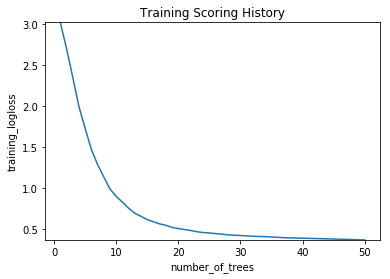

In [64]:
#HDP plot for DRF
mod_best_drf.plot()

In [65]:
#Hyperparamaters for DRF
mod_best_drf.params

{'model_id': {'default': None,
  'actual': {'__meta': {'schema_version': 3,
    'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>'},
   'name': 'DRF_1_AutoML_20190420_162320',
   'type': 'Key<Model>',
   'URL': '/3/Models/DRF_1_AutoML_20190420_162320'}},
 'training_frame': {'default': None,
  'actual': {'__meta': {'schema_version': 3,
    'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>'},
   'name': 'automl_training_adult3.hex',
   'type': 'Key<Frame>',
   'URL': '/3/Frames/automl_training_adult3.hex'}},
 'validation_frame': {'default': None, 'actual': None},
 'nfolds': {'default': 0, 'actual': 5},
 'keep_cross_validation_models': {'default': True, 'actual': False},
 'keep_cross_validation_predictions': {'default': False, 'actual': True},
 'keep_cross_validation_fold_assignment': {'default': False, 'actual': False},
 'score_each_iteration': {'default': False, 'actual': False},
 'score_tree_interval': {'default': 0, 'actual': 0},
 'fold_assignment': {'default': 'AU

In [66]:
#To check the hyperparamter values for best model and saving it 
r= run_id+'_mod_best_drf.params.json'
dict_to_json(mod_best_drf.params,r)

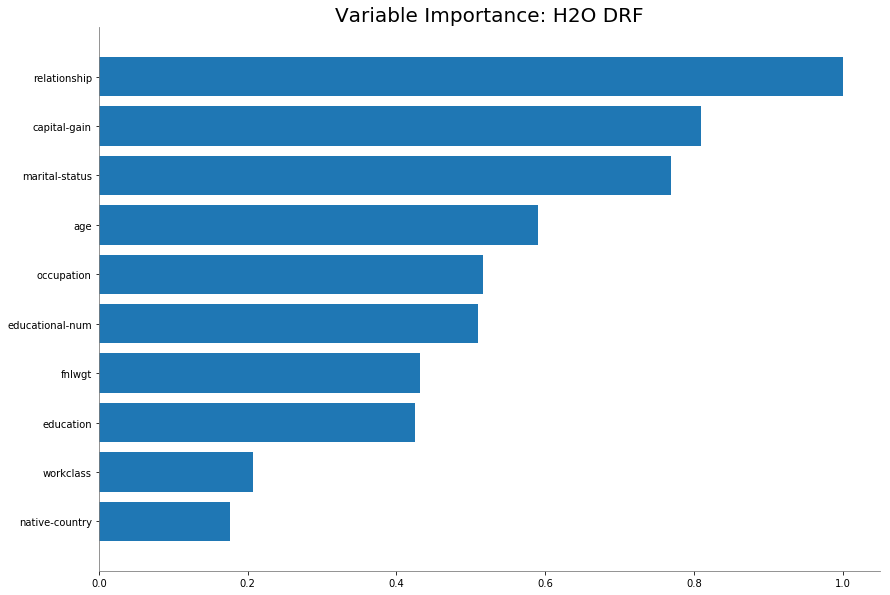

In [67]:
%matplotlib inline
mod_best_drf.varimp_plot()

In [68]:
# Get glm best model  
def get_glm_best(lst):
    se=None
    for model in model_set:
      if 'GLM' in model:
        dl=model
#     if dr is None:     
#       for model in model_set:
#         if 'AllModels'in model:
#           se=model           
    return dl 
dl=get_glm_best(model_set)
print(dl)

GLM_grid_1_AutoML_20190420_162320_model_1


In [69]:
if se is not None:
  mod_best_glm=h2o.get_model(dl)
mod_best_glm._id

'GLM_grid_1_AutoML_20190420_162320_model_1'

In [70]:
mod_best_glm.params

{'model_id': {'default': None,
  'actual': {'__meta': {'schema_version': 3,
    'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>'},
   'name': 'GLM_grid_1_AutoML_20190420_162320_model_1',
   'type': 'Key<Model>',
   'URL': '/3/Models/GLM_grid_1_AutoML_20190420_162320_model_1'}},
 'training_frame': {'default': None,
  'actual': {'__meta': {'schema_version': 3,
    'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>'},
   'name': 'automl_training_adult3.hex',
   'type': 'Key<Frame>',
   'URL': '/3/Frames/automl_training_adult3.hex'}},
 'validation_frame': {'default': None, 'actual': None},
 'nfolds': {'default': 0, 'actual': 5},
 'seed': {'default': -1, 'actual': 5225453679239142921},
 'keep_cross_validation_models': {'default': True, 'actual': False},
 'keep_cross_validation_predictions': {'default': False, 'actual': True},
 'keep_cross_validation_fold_assignment': {'default': False, 'actual': False},
 'fold_assignment': {'default': 'AUTO', 'actual': 'Modulo'},
 'fold

In [71]:
#To check the hyperparamter values for GLM best model and saving it 
o= run_id+'_mod_best_glm.params.json'
dict_to_json(mod_best_glm.params,o)

In [72]:
# Get XRT best model  
def get_xrt_best(lst):
    xr=None
    for model in model_set:
      if 'XRT' in model:
        xr=model
#     if dr is None:     
#       for model in model_set:
#         if 'AllModels'in model:
#           se=model           
    return xr 
xr=get_xrt_best(model_set)
print(xr)

XRT_1_AutoML_20190420_162320


In [73]:
if se is not None:
  mod_best_xrt=h2o.get_model(xr)
mod_best_xrt._id

'XRT_1_AutoML_20190420_162320'

In [74]:
mod_best_xrt.params

{'model_id': {'default': None,
  'actual': {'__meta': {'schema_version': 3,
    'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>'},
   'name': 'XRT_1_AutoML_20190420_162320',
   'type': 'Key<Model>',
   'URL': '/3/Models/XRT_1_AutoML_20190420_162320'}},
 'training_frame': {'default': None,
  'actual': {'__meta': {'schema_version': 3,
    'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>'},
   'name': 'automl_training_adult3.hex',
   'type': 'Key<Frame>',
   'URL': '/3/Frames/automl_training_adult3.hex'}},
 'validation_frame': {'default': None, 'actual': None},
 'nfolds': {'default': 0, 'actual': 5},
 'keep_cross_validation_models': {'default': True, 'actual': False},
 'keep_cross_validation_predictions': {'default': False, 'actual': True},
 'keep_cross_validation_fold_assignment': {'default': False, 'actual': False},
 'score_each_iteration': {'default': False, 'actual': False},
 'score_tree_interval': {'default': 0, 'actual': 0},
 'fold_assignment': {'default': 'AU

In [75]:
#To check the hyperparamter values for XRT best model and saving it 
k= run_id+'_mod_best_xrt.params.json'
dict_to_json(mod_best_xrt.params,k)

In [76]:
# Get DeepLearning best model  
def get_dl_best(lst):
    xr=None
    for model in model_set:
      if 'DeepLearning' in model:
        dl=model
#     if dr is None:     
#       for model in model_set:
#         if 'AllModels'in model:
#           se=model           
    return dl 
dl=get_dl_best(model_set)
print(dl)

DeepLearning_grid_1_AutoML_20190420_162320_model_8


In [77]:
if se is not None:
  mod_best_dl=h2o.get_model(dl)
mod_best_dl._id

'DeepLearning_grid_1_AutoML_20190420_162320_model_8'

In [78]:
mod_best_dl.params

{'model_id': {'default': None,
  'actual': {'__meta': {'schema_version': 3,
    'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>'},
   'name': 'DeepLearning_grid_1_AutoML_20190420_162320_model_8',
   'type': 'Key<Model>',
   'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190420_162320_model_8'}},
 'training_frame': {'default': None,
  'actual': {'__meta': {'schema_version': 3,
    'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>'},
   'name': 'automl_training_adult3.hex',
   'type': 'Key<Frame>',
   'URL': '/3/Frames/automl_training_adult3.hex'}},
 'validation_frame': {'default': None, 'actual': None},
 'nfolds': {'default': 0, 'actual': 5},
 'keep_cross_validation_models': {'default': True, 'actual': False},
 'keep_cross_validation_predictions': {'default': False, 'actual': True},
 'keep_cross_validation_fold_assignment': {'default': False, 'actual': False},
 'fold_assignment': {'default': 'AUTO', 'actual': 'Modulo'},
 'fold_column': {'default': None, 'actual': N

In [79]:
#To check the hyperparamter values for Deep Learning best model and saving it 
l= run_id+'_mod_best_dl.params.json'
dict_to_json(mod_best_dl.params,l)

In [80]:
bm=stackedensemble_df(aml_leaderboard_df)

In [81]:
bm

['GBM_2_AutoML_20190420_162320',
 'GLM_grid_1_AutoML_20190420_162320_model_1',
 'DRF_1_AutoML_20190420_162320',
 'XRT_1_AutoML_20190420_162320',
 'DeepLearning_1_AutoML_20190420_162320']

In [82]:

aml_leaderboard_df

,model_id,auc,logloss,mean_per_class_error,rmse,mse
0,GBM_2_AutoML_20190420_162320,0.916771,0.298813,0.182765,0.308274,0.095033
1,GBM_1_AutoML_20190420_162320,0.916534,0.299348,0.185647,0.308429,0.095128
2,GBM_3_AutoML_20190420_162320,0.916267,0.299677,0.186654,0.308808,0.095362
3,GBM_grid_1_AutoML_20190420_162320_model_8,0.916266,0.299977,0.178468,0.308689,0.095289
4,StackedEnsemble_BestOfFamily_AutoML_20190420_162320,0.915921,0.315656,0.183882,0.312316,0.097542
5,StackedEnsemble_AllModels_AutoML_20190420_162320,0.915599,0.312523,0.180072,0.311244,0.096873
6,GBM_4_AutoML_20190420_162320,0.914624,0.302621,0.183336,0.310454,0.096382
7,GBM_5_AutoML_20190420_162320,0.914432,0.302719,0.185855,0.310520,0.096423
8,GBM_grid_1_AutoML_20190420_162320_model_6,0.914004,0.304057,0.182397,0.310679,0.096521
9,GBM_grid_1_AutoML_20190420_162320_model_7,0.912660,0.315764,0.182668,0.313728,0.098425


In [83]:
#  Get best_models and coef_norm() of Leader board for GBM
best_models={}
best_models=stackedensemble(mod_best)
bm=[]
if best_models is not None: 
  if 'Intercept' in best_models.keys():
    del best_models['Intercept']
  bm=list(best_models.keys())
else:
  best_models={}
  bm=stackedensemble_df(aml_leaderboard_df)   
  for b in bm:   
    best_models[b]=None

if mod_best.model_id not in bm:
    bm.append(mod_best.model_id)

In [84]:

bm

['GBM_2_AutoML_20190420_162320',
 'XRT_1_AutoML_20190420_162320',
 'DeepLearning_1_AutoML_20190420_162320',
 'DRF_1_AutoML_20190420_162320',
 'GLM_grid_1_AutoML_20190420_162320_model_1',
 'StackedEnsemble_BestOfFamily_AutoML_20190420_162320']

In [85]:
# Best of Family leaderboard

aml_leaderboard_df=aml_leaderboard_df.loc[aml_leaderboard_df['model_id'].isin(bm)]

In [86]:
aml_leaderboard_df

,model_id,auc,logloss,mean_per_class_error,rmse,mse
0,GBM_2_AutoML_20190420_162320,0.916771,0.298813,0.182765,0.308274,0.095033
4,StackedEnsemble_BestOfFamily_AutoML_20190420_162320,0.915921,0.315656,0.183882,0.312316,0.097542
16,XRT_1_AutoML_20190420_162320,0.905568,0.316574,0.193301,0.317034,0.100510
17,DeepLearning_1_AutoML_20190420_162320,0.904317,0.322756,0.189507,0.320726,0.102865
20,DRF_1_AutoML_20190420_162320,0.903223,0.339267,0.194826,0.318780,0.101621
26,GLM_grid_1_AutoML_20190420_162320_model_1,0.898884,0.329692,0.198005,0.324408,0.105241


In [87]:
# save leaderboard
leaderboard_stats=run_id+'_leaderboard.csv'
aml_leaderboard_df.to_csv(leaderboard_stats)

In [88]:
#To check the hyperparamter values for best model and saving it 
r= run_id+'_mod_best.params.json'
dict_to_json(mod_best.params,r)

In [89]:
#This will show the model details, model summary and significant variables of Stacked ensemble
mod_best.set_params()

Model Details
H2OStackedEnsembleEstimator :  Stacked Ensemble
Model Key:  StackedEnsemble_BestOfFamily_AutoML_20190420_162320
No model summary for this model


ModelMetricsBinomialGLM: stackedensemble
** Reported on train data. **

MSE: 0.08601252088623176
RMSE: 0.2932789131291777
LogLoss: 0.2816648872434788
Null degrees of freedom: 48841
Residual degrees of freedom: 48837
Null deviance: 53750.68147229072
Residual deviance: 27514.152845491986
AIC: 27524.152845491986
AUC: 0.9371656517851344
pr_auc: 0.8059846198837787
Gini: 0.8743313035702689
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3109274633437356: 


,<=50K,>50K,Error,Rate
<=50K,33576.0,3579.0,0.0963,(3579.0/37155.0)
>50K,2647.0,9040.0,0.2265,(2647.0/11687.0)
Total,36223.0,12619.0,0.1275,(6226.0/48842.0)


Maximum Metrics: Maximum metrics at their respective thresholds



metric,threshold,value,idx
max f1,0.3109275,0.7438493,238.0
max f2,0.1173027,0.8222020,330.0
max f0point5,0.6553677,0.7741506,120.0
max accuracy,0.4771650,0.8796118,176.0
max precision,0.9623698,1.0,0.0
max recall,0.0401612,1.0,397.0
max specificity,0.9623698,1.0,0.0
max absolute_mcc,0.3109275,0.6600266,238.0
max min_per_class_accuracy,0.2027307,0.8519723,285.0
max mean_per_class_accuracy,0.1491282,0.8553477,312.0


Gains/Lift Table: Avg response rate: 23.93 %, avg score: 24.08 %



,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
,1,0.0100119,0.9618675,4.1791734,4.1791734,1.0,0.9623231,1.0,0.9623231,0.0418414,0.0418414,317.9173441,317.9173441
,2,0.0200033,0.9607632,4.1791734,4.1791734,1.0,0.9614127,1.0,0.9618684,0.0417558,0.0835972,317.9173441,317.9173441
,3,0.0300152,0.9584526,4.1791734,4.1791734,1.0,0.9597539,1.0,0.9611631,0.0418414,0.1254385,317.9173441,317.9173441
,4,0.0400066,0.9505824,4.1791734,4.1791734,1.0,0.9556792,1.0,0.9597935,0.0417558,0.1671943,317.9173441,317.9173441
,5,0.0500184,0.9222069,4.1364416,4.1706201,0.9897751,0.9355786,0.9979533,0.9549466,0.0414135,0.2086079,313.6441606,317.0620077
,6,0.1000164,0.8390397,3.6195544,3.8951436,0.8660934,0.8813437,0.9320368,0.9181527,0.1809703,0.3895782,261.9554393,289.5143639
,7,0.1500143,0.6912800,3.0445330,3.6116455,0.7285012,0.7703458,0.8642009,0.8688904,0.1522204,0.5417986,204.4532986,261.1645452
,8,0.2000123,0.4909087,2.4643775,3.3248578,0.5896806,0.5919886,0.7955778,0.7996721,0.1232138,0.6650124,146.4377459,232.4857814
,9,0.3000082,0.2273727,1.6608877,2.7702390,0.3974201,0.3364523,0.6628677,0.6452760,0.1660820,0.8310944,66.0887725,177.0238970
,10,0.4000041,0.1123816,1.0054318,2.3290598,0.2405815,0.1609882,0.5573015,0.5242103,0.1005391,0.9316334,0.5431776,132.9059754




ModelMetricsBinomialGLM: stackedensemble
** Reported on cross-validation data. **

MSE: 0.09754153450593377
RMSE: 0.31231640127590765
LogLoss: 0.3156557961586041
Null degrees of freedom: 48841
Residual degrees of freedom: 48837
Null deviance: 53753.71062321005
Residual deviance: 30834.520791957082
AIC: 30844.520791957082
AUC: 0.9159206037779684
pr_auc: 0.78967159888675
Gini: 0.8318412075559367
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3002214876211755: 


,<=50K,>50K,Error,Rate
<=50K,33041.0,4114.0,0.1107,(4114.0/37155.0)
>50K,3004.0,8683.0,0.257,(3004.0/11687.0)
Total,36045.0,12797.0,0.1457,(7118.0/48842.0)


Maximum Metrics: Maximum metrics at their respective thresholds



metric,threshold,value,idx
max f1,0.3002215,0.7092795,243.0
max f2,0.0919972,0.7933363,343.0
max f0point5,0.6755715,0.7401893,115.0
max accuracy,0.4970562,0.8649113,170.0
max precision,0.9636488,1.0,0.0
max recall,0.0391109,1.0,398.0
max specificity,0.9636488,1.0,0.0
max absolute_mcc,0.3383722,0.6148467,228.0
max min_per_class_accuracy,0.1835977,0.8297941,292.0
max mean_per_class_accuracy,0.1529225,0.8310999,307.0


Gains/Lift Table: Avg response rate: 23.93 %, avg score: 23.93 %



,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
,1,0.0100119,0.9617019,4.1791734,4.1791734,1.0,0.9627867,1.0,0.9627867,0.0418414,0.0418414,317.9173441,317.9173441
,2,0.0200033,0.9597628,4.1791734,4.1791734,1.0,0.9607801,1.0,0.9617844,0.0417558,0.0835972,317.9173441,317.9173441
,3,0.0300152,0.9570751,4.1449880,4.1677705,0.9918200,0.9585830,0.9972715,0.9607165,0.0414991,0.1250963,314.4987973,316.7770512
,4,0.0400066,0.9452496,4.1363540,4.1599244,0.9897541,0.9528295,0.9953941,0.9587468,0.0413280,0.1664242,313.6354041,315.9924433
,5,0.0500184,0.9166360,3.8971433,4.1073252,0.9325153,0.9295265,0.9828080,0.9528980,0.0390177,0.2054419,289.7143331,310.7325187
,6,0.1000164,0.8327347,3.3885190,3.7479957,0.8108108,0.8759304,0.8968270,0.9144220,0.1694190,0.3748610,238.8519006,274.7995669
,7,0.1500143,0.6784340,2.8836639,3.4599244,0.6900082,0.7607121,0.8278968,0.8631924,0.1441773,0.5190382,188.3663901,245.9924402
,8,0.2000123,0.4797121,2.3223335,3.1755558,0.5556921,0.5786774,0.7598526,0.7920709,0.1161119,0.6351502,132.2333480,217.5555784
,9,0.3000082,0.2262212,1.6052681,2.6521623,0.3841114,0.3329246,0.6346141,0.6390326,0.1605202,0.7956704,60.5268095,165.2162276
,10,0.4000041,0.1128603,1.0311024,2.2469180,0.2467240,0.1608159,0.5376465,0.5194846,0.1031060,0.8987764,3.1102374,124.6918044


In [90]:
top=aml_leaderboard_df.iloc[0]['model_id']
print(top)

GBM_2_AutoML_20190420_162320


In [91]:
mod_best_lead=h2o.get_model(top)
print(mod_best_lead._id)
print(mod_best_lead.algo)

GBM_2_AutoML_20190420_162320
gbm


In [92]:
#To check the hyperparamter values for best model and saving it 
j= run_id+'_mod_best_lead.params.json'
dict_to_json(mod_best_lead.params,j)

In [93]:
meta_data['mod_best']=mod_best._id
meta_data['mod_best_algo']=mod_best.algo
meta_data['mod_best.params'] = mod_best.params
meta_data['mod_best.varimp()'] = mod_best.varimp()


In [94]:
#Variable Imp for GBM
mod_best_lead.varimp()

[('marital-status', 5171.375, 1.0, 0.23489690397304425),
 ('capital-gain', 4577.18896484375, 0.8851009576454522, 0.20790747465449327),
 ('relationship', 3992.907958984375, 0.7721172722891639, 0.1813679567648366),
 ('education', 2028.03662109375, 0.3921658400510019, 0.09211854167196842),
 ('educational-num',
  1925.1546630859375,
  0.372271332689263,
  0.08744538348662702),
 ('occupation', 1690.8240966796875, 0.3269583228212395, 0.0768014977589283),
 ('age', 1187.188720703125, 0.2295692578285514, 0.05392510791131628),
 ('native-country',
  625.5381469726562,
  0.12096166821641367,
  0.028413521363450163),
 ('workclass', 499.7828063964844, 0.09664408525710945, 0.02270139641420194),
 ('fnlwgt', 255.03077697753906, 0.049315854483099573, 0.011584141534865264),
 ('race', 62.48165512084961, 0.012082213167842132, 0.0028380744662684643)]

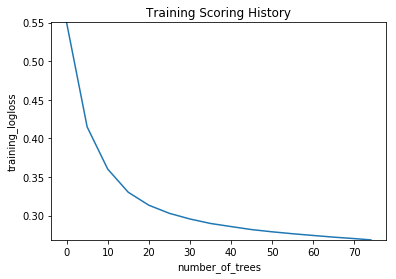

In [95]:
#Plot to see the hyper parameter dependency plot
import matplotlib.pyplot as plt
mod_best_lead.plot()

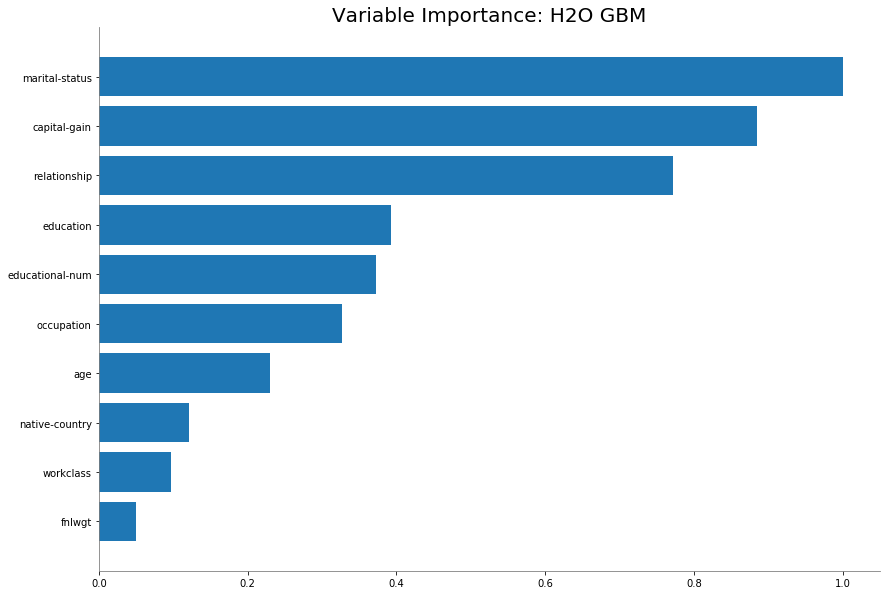

In [96]:
%matplotlib inline
mod_best_lead.varimp_plot()

In [97]:
meta_data['models']=bm

In [98]:
models_path=os.path.join(run_dir,'models')
for mod in bm:
  try:   
    m=h2o.get_model(mod) 
    h2o.save_model(m, path = models_path)
  except:    
    pass

In [99]:
print(models_path)

C:\Users\pkash\iqhzVWRCU\IpxFGNwiH\models


In [100]:
# GBM
 
# mod,mod_id=get_model_by_algo("GBM",best_models)
# if mod is not None:
#     try:     
#         sh_df=mod.scoring_history()
#         sh_df.to_csv(run_id+'_gbm_scoring_history.csv') 
#     except:
#         pass   
#     try:     
#         stats_gbm={}
#         stats_gbm=gbm_stats(mod)
#         n=run_id+'_gbm_stats.json'
#         dict_to_json(stats_gbm,n)
#         print(stats_gbm)
#     except:
#         pass

In [101]:
# if mod is not None:
#     try:    
#         sh_df=mod.scoring_history()
#         sh_df.to_csv(run_id+'_dl_scoring_history.csv') 
#     except:
#         pass 
#     try:
#         stats_dl={}
#         stats_dl=dl_stats(mod)
#         n=run_id+'_dl_stats.json'
#         dict_to_json(stats_dl,n)
#         print(stats_dl)
#     except:
#         pass    
#     try:
#         cf=mod.confusion_matrix()    
#         cf_df.to_csv(run_id+'_dl_confusion_matrix.csv')
#     except:
#         pass

In [102]:
# # DRF

# mod,mod_id=get_model_by_algo("DRF",best_models)
# if mod is not None:
#     try:     
#          sh_df=mod.scoring_history()
#          sh_df.to_csv(run_id+'_drf_scoring_history.csv') 
#     except:
#          pass  
#     try: 
#          stats_drf={}
#          stats_drf=drf_stats(mod)
#          n=run_id+'_drf_stats.json'
#          dict_to_json(stats_drf,n)
#          print(stats_drf)
#     except:
#          pass

In [103]:
# stats_xrt

In [104]:
# XRT

# mod,mod_id=get_model_by_algo("XRT",best_models)
# if mod is not None:
#     try:     
#          sh_df=mod.scoring_history()
#          sh_df.to_csv(run_id+'_xrt_scoring_history.csv')
#     except:
#          pass     
#     try:        
#          stats_xrt={}
#          stats_xrt=xrt_stats(mod)
#          n=run_id+'_xrt_stats.json'
#          dict_to_json(stats_xrt,n)
#          print(stats_xrt)
#     except:
#          pass

In [105]:
# GLM

# mod,mod_id=get_model_by_algo("GLM",best_models)
# if mod is not None:
#     try:     
#          stats_glm={}
#          stats_glm=glm_stats(mod)
#          n=run_id+'_glm_stats.json'
#          dict_to_json(stats_glm,n)
#          print(stats_glm)
#     except:
#          pass

In [106]:
def predictions_test(mod,test,run_id):
    mod_perf=mod_best.model_performance(test)          
    stats_test={}
    stats_test=model_performance_stats(mod_perf)
    n=run_id+'_test_stats.json'
    dict_to_json(stats_test,n) 
    try:
      cf=mod_perf.confusion_matrix()
#      cf=mod_perf.confusion_matrix(metrics=["f1","f2","f0point5","accuracy","precision","recall","specificity","absolute_mcc","min_per_class_accuracy","mean_per_class_accuracy"])
      cf_df=cf.table.as_data_frame()
      cf_df.to_csv(run_id+'_test_confusion_matrix.csv')
    except:
      pass
    predictions = mod_best.predict(test)    
    predictions_df=test.cbind(predictions).as_data_frame() 
    predictions_df.to_csv(run_id+'_predictions.csv')
    return predictions
predictions_df=predictions_test(mod_best,test,run_id)

stackedensemble prediction progress: |████████████████████████████████████| 100%


In [107]:

predictions_df.head()

predict,<=50K,>50K
>50K,0.412074,0.587926
<=50K,0.958295,0.0417048
<=50K,0.959995,0.0400051
<=50K,0.856516,0.143484
>50K,0.146713,0.853287
>50K,0.603359,0.396641
>50K,0.0420812,0.957919
<=50K,0.950547,0.0494528
<=50K,0.884479,0.115521
<=50K,0.960542,0.0394579


In [108]:
# Update and save meta data

meta_data['end_time'] = time.time()
meta_data['execution_time'] = meta_data['end_time'] - meta_data['start_time']
  
n=run_id+'_meta_data.json'
dict_to_json(meta_data,n)

In [109]:
meta_data

{'start_time': 1555791682.494615,
 'target': None,
 'server_path': 'C:\\Users\\pkash\\iqhzVWRCU',
 'data_path': 'C:/Users/pkash/Downloads/adult.csv',
 'test_path': None,
 'max_models': 100,
 'run_time': 1000,
 'run_id': 'IpxFGNwiH',
 'scale': False,
 'classification': False,
 'model_path': None,
 'balance': False,
 'balance_threshold': 0.2,
 'project': None,
 'end_time': 1555792831.8659692,
 'execution_time': 1149.3713541030884,
 'run_path': 'C:\\Users\\pkash\\iqhzVWRCU\\IpxFGNwiH',
 'nthreads': 1,
 'min_mem_size': 6,
 'analysis': 0,
 'x': ['age',
  'workclass',
  'fnlwgt',
  'education',
  'educational-num',
  'marital-status',
  'occupation',
  'relationship',
  'race',
  'capital-gain',
  'native-country'],
 'variables': {'age': 'int',
  'workclass': 'enum',
  'fnlwgt': 'int',
  'education': 'enum',
  'educational-num': 'int',
  'marital-status': 'enum',
  'occupation': 'enum',
  'relationship': 'enum',
  'race': 'enum',
  'gender': 'enum',
  'capital-gain': 'int',
  'capital-loss':

In [110]:
# Save logs
h2o.download_all_logs(dirname=logs_path, filename=logfile)

Writing H2O logs to C:\Users\pkash\iqhzVWRCU\IpxFGNwiH\logs\IpxFGNwiH_autoh2o_log.zip


'C:\\Users\\pkash\\iqhzVWRCU\\IpxFGNwiH\\logs\\IpxFGNwiH_autoh2o_log.zip'

In [111]:
# Clean up
os.chdir(server_path)

In [112]:
def predictions_test(mod,test,run_id):
    mod_perf=mod_best.model_performance(test)          
    stats_test={}
    stats_test=model_performance_stats(mod_perf)
    print(stats_test)   
    n=run_id+'_test_stats.json'
    dict_to_json(stats_test,n) 
    try:
      cf=mod_perf.confusion_matrix()
      print(cf)   
#      cf=mod_perf.confusion_matrix(metrics=["f1","f2","f0point5","accuracy","precision","recall","specificity","absolute_mcc","min_per_class_accuracy","mean_per_class_accuracy"])
      cf_df=cf.table.as_data_frame()
      print(cf_df)    
      cf_df.to_csv(run_id+'_test_confusion_matrix.csv')
    except:
      pass
    predictions = mod_best.predict(test)    
    predictions_df=test.cbind(predictions).as_data_frame() 
    predictions_df.to_csv(run_id+'_predictions.csv')
    return predictions

In [113]:
# -------------------------------------------------------------
#Grid Search on GBM using hyperparameters from automl run
#--------------------------------------------------------------

gbm_params = {'learn_rate': 0.1,
                'max_depth': 15,
                'sample_rate': 0.8,
                'col_sample_rate': 0.8,
                'max_abs_leafnode_pred' : 1.7976931348623157e+308,
                 'balance_classes' : False,
                 'distribution' : "bernoulli",
              }
# Search criteria
search_criteria = {'strategy': 'RandomDiscrete', 'max_models': 100,'seed': 1344887278173816842, 'stopping_rounds' : 0 , "max_runtime_secs":0,
                  "stopping_metric": 'logloss', "stopping_tolerance": 0.004524840555912091}


               

In [114]:


# Train and validate a cartesian grid of GBMs
gbm_grid_4 = H2OGridSearch(model=H2OGradientBoostingEstimator,
                          grid_id='gbm_grid_4',
                           
                          hyper_params=gbm_params,
                          search_criteria=search_criteria)

#Training Model on the adults.csv data
gbm_grid_4.train(x=x, y=y,
               training_frame=train,
               validation_frame=test,
               
               ntrees = 64)

gbm Grid Build progress: |████████████████████████████████████████████████| 100%


In [ ]:
# Get the grid results, sorted by validation AUC
# gbm_gridperf = gbm_grid.get_grid(sort_by=None, decreasing=None)
# gbm_gridperf



In [ ]:
# Grab the top GBM model, chosen by validation AUC
# best_gbm2 = gbm_gridperf2.models[0]
# best_gbm2

In [115]:
# Now let's evaluate the model performance on a test set
# so we get an honest estimate of top model performance
best_gbm4= gbm_grid_4.model_performance(test)

best_gbm4


ModelMetricsBinomial: gbm
** Reported on test data. **

MSE: 0.10462482915891586
RMSE: 0.32345761570709053
LogLoss: 0.329930723264562
Mean Per-Class Error: 0.17848876344513864
AUC: 0.9050607480487324
pr_auc: 0.7502942715566568
Gini: 0.8101214960974648
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3376984504150638: 


,<=50K,>50K,Error,Rate
<=50K,9700.0,1403.0,0.1264,(1403.0/11103.0)
>50K,935.0,2603.0,0.2643,(935.0/3538.0)
Total,10635.0,4006.0,0.1597,(2338.0/14641.0)


Maximum Metrics: Maximum metrics at their respective thresholds



metric,threshold,value,idx
max f1,0.3376985,0.6900848,225.0
max f2,0.0821820,0.7870013,334.0
max f0point5,0.6214606,0.7152620,126.0
max accuracy,0.5818947,0.8513763,138.0
max precision,0.9971075,1.0,0.0
max recall,0.0023903,1.0,396.0
max specificity,0.9971075,1.0,0.0
max absolute_mcc,0.3510083,0.5859408,220.0
max min_per_class_accuracy,0.2145923,0.8169864,272.0
max mean_per_class_accuracy,0.1658584,0.8215112,293.0


Gains/Lift Table: Avg response rate: 24.17 %, avg score: 23.16 %



,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
,1,0.0100403,0.9962859,4.1382137,4.1382137,1.0,0.9968574,1.0,0.9968574,0.0415489,0.0415489,313.8213680,313.8213680
,2,0.0200123,0.9954000,4.1382137,4.1382137,1.0,0.9958348,1.0,0.9963478,0.0412663,0.0828151,313.8213680,313.8213680
,3,0.0300526,0.9937168,4.1100626,4.1288086,0.9931973,0.9946942,0.9977273,0.9957954,0.0412663,0.1240814,311.0062567,312.8808649
,4,0.0400246,0.9886694,4.0815258,4.1170283,0.9863014,0.9919547,0.9948805,0.9948385,0.0407010,0.1647824,308.1525821,311.7028286
,5,0.0500649,0.9464512,3.8285514,4.0591755,0.9251701,0.9715614,0.9809004,0.9901704,0.0384398,0.2032222,282.8551432,305.9175492
,6,0.1000615,0.8068575,3.1771531,3.6184653,0.7677596,0.8725516,0.8744027,0.9314011,0.1588468,0.3620690,217.7153126,261.8465341
,7,0.1500581,0.6616776,2.7079294,3.3150915,0.6543716,0.7375097,0.8010924,0.8668001,0.1353872,0.4974562,170.7929444,231.5091523
,8,0.2000546,0.5077519,2.0747601,3.0051145,0.5013661,0.5842080,0.7261864,0.7961762,0.1037309,0.6011871,107.4760137,200.5114543
,9,0.3000478,0.2848911,1.6903359,2.5669548,0.4084699,0.3887514,0.6203050,0.6603989,0.1690220,0.7702092,69.0335916,156.6954764
,10,0.4000410,0.1270264,1.1334861,2.2086488,0.2739071,0.1978845,0.5337203,0.5447900,0.1133409,0.8835500,13.3486124,120.8648790


{'gbm_grid_4_model_1': }

In [116]:
#Checking the auc

gbm_grid_4.auc()

{'gbm_grid_4_model_1': 0.9868181102891397}

In [117]:
#HDP plot for GBM
# import matplotlib.pyplot as plt
# gbm_grid_2.plot()

In [118]:
#VIMP plot for GBM
# import matplotlib.pyplot as plt
# best_gbm2.varimp_plot()

In [119]:
# -------------------------------------------------------------
#Grid Search on DRF using hyperparameters from automl run
#--------------------------------------------------------------

drf_params = {'mtries': -1,
                'categorical_encoding':"Auto",
                'distribution' : "multinomial",
                'sample_rate' : 0.6320000290870667,
                'max_depth': 20
                
              }
# Search criteria
search_criteria = {'strategy': 'RandomDiscrete', 'max_models': 100,'seed': 2278995042385754392, 'stopping_rounds' : 0 , "max_runtime_secs":0,
                  "stopping_metric": 'logloss', "stopping_tolerance": 0.004524840555912091}



In [120]:
# Train and validate a cartesian grid of DRFs
drf_grid_4 = H2OGridSearch(model=H2ORandomForestEstimator,
                          grid_id='drf_grid_4',
                          hyper_params=drf_params,
                          search_criteria=search_criteria)

#Training Model on the adults.csv data
drf_grid_4.train(x=x, y=y,
               training_frame=train,
               validation_frame=test,
               ntrees = 50)

drf Grid Build progress: |████████████████████████████████████████████████| 100%


In [121]:
# Grab the top DRF model

best_perf_4_drf = drf_grid_4.model_performance()

best_perf_4_drf 


ModelMetricsBinomial: drf
** Reported on train data. **

MSE: 0.10317540220358498
RMSE: 0.3212092810047446
LogLoss: 0.394545438664093
Mean Per-Class Error: 0.1861748363906337
AUC: 0.8990308860930545
pr_auc: 0.6565269469778477
Gini: 0.798061772186109
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3718010564544977: 


,<=50K,>50K,Error,Rate
<=50K,22806.0,3246.0,0.1246,(3246.0/26052.0)
>50K,2180.0,5969.0,0.2675,(2180.0/8149.0)
Total,24986.0,9215.0,0.1587,(5426.0/34201.0)


Maximum Metrics: Maximum metrics at their respective thresholds



metric,threshold,value,idx
max f1,0.3718011,0.6875144,212.0
max f2,0.1750880,0.7720643,300.0
max f0point5,0.5778731,0.7158109,134.0
max accuracy,0.5133742,0.8559691,156.0
max precision,0.9892922,0.9956379,2.0
max recall,0.0000178,1.0,399.0
max specificity,0.9999961,0.9998465,0.0
max absolute_mcc,0.4299108,0.5841189,187.0
max min_per_class_accuracy,0.2802861,0.8122469,252.0
max mean_per_class_accuracy,0.2338134,0.8138252,273.0


Gains/Lift Table: Avg response rate: 23.83 %, avg score: 24.18 %



,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
,1,0.0260226,1.0,4.1780940,4.1780940,0.9955056,1.0,0.9955056,1.0,0.1087250,0.1087250,317.8093955,317.8093955
,2,0.0300284,0.9603168,3.8293400,4.1315708,0.9124088,0.9756321,0.9844206,0.9967494,0.0153393,0.1240643,282.9340038,313.1570794
,3,0.0403789,0.9285714,3.8887056,4.0693157,0.9265537,0.9442068,0.9695873,0.9832808,0.0402503,0.1643146,288.8705626,306.9315711
,4,0.0500278,0.8899937,3.5737722,3.9737404,0.8515152,0.9085577,0.9468147,0.9688690,0.0344828,0.1987974,257.3772205,297.3740400
,5,0.1000263,0.7618120,3.2692084,3.6215774,0.7789474,0.8230807,0.8629056,0.8959961,0.1634556,0.3622530,226.9208363,262.1577353
,6,0.1500541,0.6315789,2.8159592,3.3529857,0.6709527,0.6975791,0.7989088,0.8298442,0.1408762,0.5031292,181.5959246,235.2985658
,7,0.2000234,0.4991682,2.2814352,3.0852938,0.5435927,0.5623401,0.7351264,0.7630171,0.1140017,0.6171309,128.1435200,208.5293839
,8,0.3000205,0.3277662,1.5364298,2.5690561,0.3660819,0.4026055,0.6121236,0.6428916,0.1536385,0.7707694,53.6429756,156.9056127
,9,0.4000175,0.1977479,1.0394217,2.1866755,0.2476608,0.2608045,0.5210145,0.5473768,0.1039391,0.8747086,3.9421728,118.6675479
,10,0.5002485,0.1000000,0.5937935,1.8675218,0.1414819,0.1454999,0.4449705,0.4668558,0.0595165,0.9342251,-40.6206537,86.7521843


{'drf_grid_4_model_1': }

In [122]:
#Grab the auc of the model

drf_grid_4.auc()



{'drf_grid_4_model_1': 0.8990308860930545}

In [123]:
# -------------------------------------------------------------
#Grid Search on GLM using hyperparameters from automl run
#--------------------------------------------------------------

glm_params = {'tweedie_variance_power': 0,
                'tweedie_link_power':1.0,
                'theta' : 1e-10,
                'missing_values_handling': "MeanImputation",
                
                
                'alpha' : [0.0,0.2,0.4,0.6,0.8,1.0],
                'lambda' : [14.190629444115807,8.812621300901148,5.472787130334066,3.398693527303556,2.110646260752699,1.3107470862675006,
                            0.813996147107118,0.5055053979879761,0.3139274163681697,0.19495424408887968,0.1210698884728571,0.07518645189456613,
                            0.04669206042724046,0.028996560577140867,0.018007355374989435,0.011182872766530513,0.006944753447033205,
                            0.004312809547867441,0.0026783277963773667,0.0016632869374894371,0.0010329293674078712,0.0006414666369376214,
                            0.00039836164919646624,0.0002473893331508685,0.00015363296712994504,9.540867542076526e-05,
                            5.9250403839728236e-05,3.679550459838807e-05,2.2850631741047847e-05,1.4190629444115783e-05]
                
        
              
        
              }
# Search criteria
search_criteria = {'strategy': 'RandomDiscrete', 'max_models': 100,'seed': 5225453679239142921}



In [124]:
# Train and validate a cartesian grid of GLM
glm_grid_4 = H2OGridSearch(model=H2OGeneralizedLinearEstimator,
                          grid_id='glm_grid_4',
                          hyper_params=glm_params,
                          search_criteria=search_criteria)

#Training Model on the adults.csv data
glm_grid_4.train(x=x, y=y,
               training_frame=train,
               validation_frame=test,
               )

glm Grid Build progress: |████████████████████████████████████████████████| 100%
Errors/Warnings building gridsearch model

Hyper-parameter: alpha, [0.0]
Hyper-parameter: lambda, [0.028996560577140867]
Hyper-parameter: missing_values_handling, MeanImputation
Hyper-parameter: theta, 1e-10
Hyper-parameter: tweedie_link_power, 1.0
Hyper-parameter: tweedie_variance_power, 0.0
failure_details: Illegal argument(s) for GLM model: glm_grid_4_model_1.  Details: ERRR on field: _response: Regression requires numeric response, got categorical.

For more information visit:
  http://jira.h2o.ai/browse/TN-2

failure_stack_traces: water.exceptions.H2OModelBuilderIllegalArgumentException: Illegal argument(s) for GLM model: glm_grid_4_model_1.  Details: ERRR on field: _response: Regression requires numeric response, got categorical.

For more information visit:
  http://jira.h2o.ai/browse/TN-2

	at water.exceptions.H2OModelBuilderIllegalArgumentException.makeFromBuilder(H2OModelBuilderIllegalArgumentExc


Hyper-parameter: alpha, [0.2]
Hyper-parameter: lambda, [0.19495424408887968]
Hyper-parameter: missing_values_handling, MeanImputation
Hyper-parameter: theta, 1e-10
Hyper-parameter: tweedie_link_power, 1.0
Hyper-parameter: tweedie_variance_power, 0.0
failure_details: Illegal argument(s) for GLM model: glm_grid_4_model_6.  Details: ERRR on field: _response: Regression requires numeric response, got categorical.

For more information visit:
  http://jira.h2o.ai/browse/TN-2

failure_stack_traces: water.exceptions.H2OModelBuilderIllegalArgumentException: Illegal argument(s) for GLM model: glm_grid_4_model_6.  Details: ERRR on field: _response: Regression requires numeric response, got categorical.

For more information visit:
  http://jira.h2o.ai/browse/TN-2

	at water.exceptions.H2OModelBuilderIllegalArgumentException.makeFromBuilder(H2OModelBuilderIllegalArgumentException.java:20)
	at hex.glm.GLM$GLMDriver.computeImpl(GLM.java:1220)
	at hex.ModelBuilder$Driver.compute2(ModelBuilder.java:


Hyper-parameter: alpha, [0.6]
Hyper-parameter: lambda, [0.19495424408887968]
Hyper-parameter: missing_values_handling, MeanImputation
Hyper-parameter: theta, 1e-10
Hyper-parameter: tweedie_link_power, 1.0
Hyper-parameter: tweedie_variance_power, 0.0
failure_details: Illegal argument(s) for GLM model: glm_grid_4_model_11.  Details: ERRR on field: _response: Regression requires numeric response, got categorical.

For more information visit:
  http://jira.h2o.ai/browse/TN-2

failure_stack_traces: water.exceptions.H2OModelBuilderIllegalArgumentException: Illegal argument(s) for GLM model: glm_grid_4_model_11.  Details: ERRR on field: _response: Regression requires numeric response, got categorical.

For more information visit:
  http://jira.h2o.ai/browse/TN-2

	at water.exceptions.H2OModelBuilderIllegalArgumentException.makeFromBuilder(H2OModelBuilderIllegalArgumentException.java:20)
	at hex.glm.GLM$GLMDriver.computeImpl(GLM.java:1220)
	at hex.ModelBuilder$Driver.compute2(ModelBuilder.jav


Hyper-parameter: alpha, [0.2]
Hyper-parameter: lambda, [0.0010329293674078712]
Hyper-parameter: missing_values_handling, MeanImputation
Hyper-parameter: theta, 1e-10
Hyper-parameter: tweedie_link_power, 1.0
Hyper-parameter: tweedie_variance_power, 0.0
failure_details: Illegal argument(s) for GLM model: glm_grid_4_model_16.  Details: ERRR on field: _response: Regression requires numeric response, got categorical.

For more information visit:
  http://jira.h2o.ai/browse/TN-2

failure_stack_traces: water.exceptions.H2OModelBuilderIllegalArgumentException: Illegal argument(s) for GLM model: glm_grid_4_model_16.  Details: ERRR on field: _response: Regression requires numeric response, got categorical.

For more information visit:
  http://jira.h2o.ai/browse/TN-2

	at water.exceptions.H2OModelBuilderIllegalArgumentException.makeFromBuilder(H2OModelBuilderIllegalArgumentException.java:20)
	at hex.glm.GLM$GLMDriver.computeImpl(GLM.java:1220)
	at hex.ModelBuilder$Driver.compute2(ModelBuilder.j


Hyper-parameter: alpha, [0.4]
Hyper-parameter: lambda, [9.540867542076526e-05]
Hyper-parameter: missing_values_handling, MeanImputation
Hyper-parameter: theta, 1e-10
Hyper-parameter: tweedie_link_power, 1.0
Hyper-parameter: tweedie_variance_power, 0.0
failure_details: Illegal argument(s) for GLM model: glm_grid_4_model_21.  Details: ERRR on field: _response: Regression requires numeric response, got categorical.

For more information visit:
  http://jira.h2o.ai/browse/TN-2

failure_stack_traces: water.exceptions.H2OModelBuilderIllegalArgumentException: Illegal argument(s) for GLM model: glm_grid_4_model_21.  Details: ERRR on field: _response: Regression requires numeric response, got categorical.

For more information visit:
  http://jira.h2o.ai/browse/TN-2

	at water.exceptions.H2OModelBuilderIllegalArgumentException.makeFromBuilder(H2OModelBuilderIllegalArgumentException.java:20)
	at hex.glm.GLM$GLMDriver.computeImpl(GLM.java:1220)
	at hex.ModelBuilder$Driver.compute2(ModelBuilder.j


Hyper-parameter: alpha, [1.0]
Hyper-parameter: lambda, [0.0016632869374894371]
Hyper-parameter: missing_values_handling, MeanImputation
Hyper-parameter: theta, 1e-10
Hyper-parameter: tweedie_link_power, 1.0
Hyper-parameter: tweedie_variance_power, 0.0
failure_details: Illegal argument(s) for GLM model: glm_grid_4_model_26.  Details: ERRR on field: _response: Regression requires numeric response, got categorical.

For more information visit:
  http://jira.h2o.ai/browse/TN-2

failure_stack_traces: water.exceptions.H2OModelBuilderIllegalArgumentException: Illegal argument(s) for GLM model: glm_grid_4_model_26.  Details: ERRR on field: _response: Regression requires numeric response, got categorical.

For more information visit:
  http://jira.h2o.ai/browse/TN-2

	at water.exceptions.H2OModelBuilderIllegalArgumentException.makeFromBuilder(H2OModelBuilderIllegalArgumentException.java:20)
	at hex.glm.GLM$GLMDriver.computeImpl(GLM.java:1220)
	at hex.ModelBuilder$Driver.compute2(ModelBuilder.j


Hyper-parameter: alpha, [0.4]
Hyper-parameter: lambda, [0.0026783277963773667]
Hyper-parameter: missing_values_handling, MeanImputation
Hyper-parameter: theta, 1e-10
Hyper-parameter: tweedie_link_power, 1.0
Hyper-parameter: tweedie_variance_power, 0.0
failure_details: Illegal argument(s) for GLM model: glm_grid_4_model_31.  Details: ERRR on field: _response: Regression requires numeric response, got categorical.

For more information visit:
  http://jira.h2o.ai/browse/TN-2

failure_stack_traces: water.exceptions.H2OModelBuilderIllegalArgumentException: Illegal argument(s) for GLM model: glm_grid_4_model_31.  Details: ERRR on field: _response: Regression requires numeric response, got categorical.

For more information visit:
  http://jira.h2o.ai/browse/TN-2

	at water.exceptions.H2OModelBuilderIllegalArgumentException.makeFromBuilder(H2OModelBuilderIllegalArgumentException.java:20)
	at hex.glm.GLM$GLMDriver.computeImpl(GLM.java:1220)
	at hex.ModelBuilder$Driver.compute2(ModelBuilder.j


Hyper-parameter: alpha, [0.2]
Hyper-parameter: lambda, [0.028996560577140867]
Hyper-parameter: missing_values_handling, MeanImputation
Hyper-parameter: theta, 1e-10
Hyper-parameter: tweedie_link_power, 1.0
Hyper-parameter: tweedie_variance_power, 0.0
failure_details: Illegal argument(s) for GLM model: glm_grid_4_model_36.  Details: ERRR on field: _response: Regression requires numeric response, got categorical.

For more information visit:
  http://jira.h2o.ai/browse/TN-2

failure_stack_traces: water.exceptions.H2OModelBuilderIllegalArgumentException: Illegal argument(s) for GLM model: glm_grid_4_model_36.  Details: ERRR on field: _response: Regression requires numeric response, got categorical.

For more information visit:
  http://jira.h2o.ai/browse/TN-2

	at water.exceptions.H2OModelBuilderIllegalArgumentException.makeFromBuilder(H2OModelBuilderIllegalArgumentException.java:20)
	at hex.glm.GLM$GLMDriver.computeImpl(GLM.java:1220)
	at hex.ModelBuilder$Driver.compute2(ModelBuilder.ja


Hyper-parameter: alpha, [0.6]
Hyper-parameter: lambda, [0.00039836164919646624]
Hyper-parameter: missing_values_handling, MeanImputation
Hyper-parameter: theta, 1e-10
Hyper-parameter: tweedie_link_power, 1.0
Hyper-parameter: tweedie_variance_power, 0.0
failure_details: Illegal argument(s) for GLM model: glm_grid_4_model_41.  Details: ERRR on field: _response: Regression requires numeric response, got categorical.

For more information visit:
  http://jira.h2o.ai/browse/TN-2

failure_stack_traces: water.exceptions.H2OModelBuilderIllegalArgumentException: Illegal argument(s) for GLM model: glm_grid_4_model_41.  Details: ERRR on field: _response: Regression requires numeric response, got categorical.

For more information visit:
  http://jira.h2o.ai/browse/TN-2

	at water.exceptions.H2OModelBuilderIllegalArgumentException.makeFromBuilder(H2OModelBuilderIllegalArgumentException.java:20)
	at hex.glm.GLM$GLMDriver.computeImpl(GLM.java:1220)
	at hex.ModelBuilder$Driver.compute2(ModelBuilder.


Hyper-parameter: alpha, [0.4]
Hyper-parameter: lambda, [2.110646260752699]
Hyper-parameter: missing_values_handling, MeanImputation
Hyper-parameter: theta, 1e-10
Hyper-parameter: tweedie_link_power, 1.0
Hyper-parameter: tweedie_variance_power, 0.0
failure_details: Illegal argument(s) for GLM model: glm_grid_4_model_46.  Details: ERRR on field: _response: Regression requires numeric response, got categorical.

For more information visit:
  http://jira.h2o.ai/browse/TN-2

failure_stack_traces: water.exceptions.H2OModelBuilderIllegalArgumentException: Illegal argument(s) for GLM model: glm_grid_4_model_46.  Details: ERRR on field: _response: Regression requires numeric response, got categorical.

For more information visit:
  http://jira.h2o.ai/browse/TN-2

	at water.exceptions.H2OModelBuilderIllegalArgumentException.makeFromBuilder(H2OModelBuilderIllegalArgumentException.java:20)
	at hex.glm.GLM$GLMDriver.computeImpl(GLM.java:1220)
	at hex.ModelBuilder$Driver.compute2(ModelBuilder.java:


Hyper-parameter: alpha, [0.4]
Hyper-parameter: lambda, [3.398693527303556]
Hyper-parameter: missing_values_handling, MeanImputation
Hyper-parameter: theta, 1e-10
Hyper-parameter: tweedie_link_power, 1.0
Hyper-parameter: tweedie_variance_power, 0.0
failure_details: Illegal argument(s) for GLM model: glm_grid_4_model_51.  Details: ERRR on field: _response: Regression requires numeric response, got categorical.

For more information visit:
  http://jira.h2o.ai/browse/TN-2

failure_stack_traces: water.exceptions.H2OModelBuilderIllegalArgumentException: Illegal argument(s) for GLM model: glm_grid_4_model_51.  Details: ERRR on field: _response: Regression requires numeric response, got categorical.

For more information visit:
  http://jira.h2o.ai/browse/TN-2

	at water.exceptions.H2OModelBuilderIllegalArgumentException.makeFromBuilder(H2OModelBuilderIllegalArgumentException.java:20)
	at hex.glm.GLM$GLMDriver.computeImpl(GLM.java:1220)
	at hex.ModelBuilder$Driver.compute2(ModelBuilder.java:


Hyper-parameter: alpha, [1.0]
Hyper-parameter: lambda, [3.398693527303556]
Hyper-parameter: missing_values_handling, MeanImputation
Hyper-parameter: theta, 1e-10
Hyper-parameter: tweedie_link_power, 1.0
Hyper-parameter: tweedie_variance_power, 0.0
failure_details: Illegal argument(s) for GLM model: glm_grid_4_model_56.  Details: ERRR on field: _response: Regression requires numeric response, got categorical.

For more information visit:
  http://jira.h2o.ai/browse/TN-2

failure_stack_traces: water.exceptions.H2OModelBuilderIllegalArgumentException: Illegal argument(s) for GLM model: glm_grid_4_model_56.  Details: ERRR on field: _response: Regression requires numeric response, got categorical.

For more information visit:
  http://jira.h2o.ai/browse/TN-2

	at water.exceptions.H2OModelBuilderIllegalArgumentException.makeFromBuilder(H2OModelBuilderIllegalArgumentException.java:20)
	at hex.glm.GLM$GLMDriver.computeImpl(GLM.java:1220)
	at hex.ModelBuilder$Driver.compute2(ModelBuilder.java:


Hyper-parameter: alpha, [0.6]
Hyper-parameter: lambda, [5.9250403839728236e-05]
Hyper-parameter: missing_values_handling, MeanImputation
Hyper-parameter: theta, 1e-10
Hyper-parameter: tweedie_link_power, 1.0
Hyper-parameter: tweedie_variance_power, 0.0
failure_details: Illegal argument(s) for GLM model: glm_grid_4_model_61.  Details: ERRR on field: _response: Regression requires numeric response, got categorical.

For more information visit:
  http://jira.h2o.ai/browse/TN-2

failure_stack_traces: water.exceptions.H2OModelBuilderIllegalArgumentException: Illegal argument(s) for GLM model: glm_grid_4_model_61.  Details: ERRR on field: _response: Regression requires numeric response, got categorical.

For more information visit:
  http://jira.h2o.ai/browse/TN-2

	at water.exceptions.H2OModelBuilderIllegalArgumentException.makeFromBuilder(H2OModelBuilderIllegalArgumentException.java:20)
	at hex.glm.GLM$GLMDriver.computeImpl(GLM.java:1220)
	at hex.ModelBuilder$Driver.compute2(ModelBuilder.


Hyper-parameter: alpha, [0.6]
Hyper-parameter: lambda, [0.0002473893331508685]
Hyper-parameter: missing_values_handling, MeanImputation
Hyper-parameter: theta, 1e-10
Hyper-parameter: tweedie_link_power, 1.0
Hyper-parameter: tweedie_variance_power, 0.0
failure_details: Illegal argument(s) for GLM model: glm_grid_4_model_66.  Details: ERRR on field: _response: Regression requires numeric response, got categorical.

For more information visit:
  http://jira.h2o.ai/browse/TN-2

failure_stack_traces: water.exceptions.H2OModelBuilderIllegalArgumentException: Illegal argument(s) for GLM model: glm_grid_4_model_66.  Details: ERRR on field: _response: Regression requires numeric response, got categorical.

For more information visit:
  http://jira.h2o.ai/browse/TN-2

	at water.exceptions.H2OModelBuilderIllegalArgumentException.makeFromBuilder(H2OModelBuilderIllegalArgumentException.java:20)
	at hex.glm.GLM$GLMDriver.computeImpl(GLM.java:1220)
	at hex.ModelBuilder$Driver.compute2(ModelBuilder.j


Hyper-parameter: alpha, [0.8]
Hyper-parameter: lambda, [2.2850631741047847e-05]
Hyper-parameter: missing_values_handling, MeanImputation
Hyper-parameter: theta, 1e-10
Hyper-parameter: tweedie_link_power, 1.0
Hyper-parameter: tweedie_variance_power, 0.0
failure_details: Illegal argument(s) for GLM model: glm_grid_4_model_71.  Details: ERRR on field: _response: Regression requires numeric response, got categorical.

For more information visit:
  http://jira.h2o.ai/browse/TN-2

failure_stack_traces: water.exceptions.H2OModelBuilderIllegalArgumentException: Illegal argument(s) for GLM model: glm_grid_4_model_71.  Details: ERRR on field: _response: Regression requires numeric response, got categorical.

For more information visit:
  http://jira.h2o.ai/browse/TN-2

	at water.exceptions.H2OModelBuilderIllegalArgumentException.makeFromBuilder(H2OModelBuilderIllegalArgumentException.java:20)
	at hex.glm.GLM$GLMDriver.computeImpl(GLM.java:1220)
	at hex.ModelBuilder$Driver.compute2(ModelBuilder.


Hyper-parameter: alpha, [0.4]
Hyper-parameter: lambda, [0.0016632869374894371]
Hyper-parameter: missing_values_handling, MeanImputation
Hyper-parameter: theta, 1e-10
Hyper-parameter: tweedie_link_power, 1.0
Hyper-parameter: tweedie_variance_power, 0.0
failure_details: Illegal argument(s) for GLM model: glm_grid_4_model_76.  Details: ERRR on field: _response: Regression requires numeric response, got categorical.

For more information visit:
  http://jira.h2o.ai/browse/TN-2

failure_stack_traces: water.exceptions.H2OModelBuilderIllegalArgumentException: Illegal argument(s) for GLM model: glm_grid_4_model_76.  Details: ERRR on field: _response: Regression requires numeric response, got categorical.

For more information visit:
  http://jira.h2o.ai/browse/TN-2

	at water.exceptions.H2OModelBuilderIllegalArgumentException.makeFromBuilder(H2OModelBuilderIllegalArgumentException.java:20)
	at hex.glm.GLM$GLMDriver.computeImpl(GLM.java:1220)
	at hex.ModelBuilder$Driver.compute2(ModelBuilder.j


Hyper-parameter: alpha, [1.0]
Hyper-parameter: lambda, [0.018007355374989435]
Hyper-parameter: missing_values_handling, MeanImputation
Hyper-parameter: theta, 1e-10
Hyper-parameter: tweedie_link_power, 1.0
Hyper-parameter: tweedie_variance_power, 0.0
failure_details: Illegal argument(s) for GLM model: glm_grid_4_model_81.  Details: ERRR on field: _response: Regression requires numeric response, got categorical.

For more information visit:
  http://jira.h2o.ai/browse/TN-2

failure_stack_traces: water.exceptions.H2OModelBuilderIllegalArgumentException: Illegal argument(s) for GLM model: glm_grid_4_model_81.  Details: ERRR on field: _response: Regression requires numeric response, got categorical.

For more information visit:
  http://jira.h2o.ai/browse/TN-2

	at water.exceptions.H2OModelBuilderIllegalArgumentException.makeFromBuilder(H2OModelBuilderIllegalArgumentException.java:20)
	at hex.glm.GLM$GLMDriver.computeImpl(GLM.java:1220)
	at hex.ModelBuilder$Driver.compute2(ModelBuilder.ja


Hyper-parameter: alpha, [0.4]
Hyper-parameter: lambda, [0.07518645189456613]
Hyper-parameter: missing_values_handling, MeanImputation
Hyper-parameter: theta, 1e-10
Hyper-parameter: tweedie_link_power, 1.0
Hyper-parameter: tweedie_variance_power, 0.0
failure_details: Illegal argument(s) for GLM model: glm_grid_4_model_86.  Details: ERRR on field: _response: Regression requires numeric response, got categorical.

For more information visit:
  http://jira.h2o.ai/browse/TN-2

failure_stack_traces: water.exceptions.H2OModelBuilderIllegalArgumentException: Illegal argument(s) for GLM model: glm_grid_4_model_86.  Details: ERRR on field: _response: Regression requires numeric response, got categorical.

For more information visit:
  http://jira.h2o.ai/browse/TN-2

	at water.exceptions.H2OModelBuilderIllegalArgumentException.makeFromBuilder(H2OModelBuilderIllegalArgumentException.java:20)
	at hex.glm.GLM$GLMDriver.computeImpl(GLM.java:1220)
	at hex.ModelBuilder$Driver.compute2(ModelBuilder.jav


Hyper-parameter: alpha, [0.2]
Hyper-parameter: lambda, [0.00039836164919646624]
Hyper-parameter: missing_values_handling, MeanImputation
Hyper-parameter: theta, 1e-10
Hyper-parameter: tweedie_link_power, 1.0
Hyper-parameter: tweedie_variance_power, 0.0
failure_details: Illegal argument(s) for GLM model: glm_grid_4_model_91.  Details: ERRR on field: _response: Regression requires numeric response, got categorical.

For more information visit:
  http://jira.h2o.ai/browse/TN-2

failure_stack_traces: water.exceptions.H2OModelBuilderIllegalArgumentException: Illegal argument(s) for GLM model: glm_grid_4_model_91.  Details: ERRR on field: _response: Regression requires numeric response, got categorical.

For more information visit:
  http://jira.h2o.ai/browse/TN-2

	at water.exceptions.H2OModelBuilderIllegalArgumentException.makeFromBuilder(H2OModelBuilderIllegalArgumentException.java:20)
	at hex.glm.GLM$GLMDriver.computeImpl(GLM.java:1220)
	at hex.ModelBuilder$Driver.compute2(ModelBuilder.


Hyper-parameter: alpha, [0.0]
Hyper-parameter: lambda, [2.2850631741047847e-05]
Hyper-parameter: missing_values_handling, MeanImputation
Hyper-parameter: theta, 1e-10
Hyper-parameter: tweedie_link_power, 1.0
Hyper-parameter: tweedie_variance_power, 0.0
failure_details: Illegal argument(s) for GLM model: glm_grid_4_model_96.  Details: ERRR on field: _response: Regression requires numeric response, got categorical.

For more information visit:
  http://jira.h2o.ai/browse/TN-2

failure_stack_traces: water.exceptions.H2OModelBuilderIllegalArgumentException: Illegal argument(s) for GLM model: glm_grid_4_model_96.  Details: ERRR on field: _response: Regression requires numeric response, got categorical.

For more information visit:
  http://jira.h2o.ai/browse/TN-2

	at water.exceptions.H2OModelBuilderIllegalArgumentException.makeFromBuilder(H2OModelBuilderIllegalArgumentException.java:20)
	at hex.glm.GLM$GLMDriver.computeImpl(GLM.java:1220)
	at hex.ModelBuilder$Driver.compute2(ModelBuilder.

ValueError: Illegal argument(s) for GLM model: glm_grid_4_model_1.  Details: ERRR on field: _response: Regression requires numeric response, got categorical.

For more information visit:
  http://jira.h2o.ai/browse/TN-2

Illegal argument(s) for GLM model: glm_grid_4_model_2.  Details: ERRR on field: _response: Regression requires numeric response, got categorical.

For more information visit:
  http://jira.h2o.ai/browse/TN-2

Illegal argument(s) for GLM model: glm_grid_4_model_3.  Details: ERRR on field: _response: Regression requires numeric response, got categorical.

For more information visit:
  http://jira.h2o.ai/browse/TN-2

Illegal argument(s) for GLM model: glm_grid_4_model_4.  Details: ERRR on field: _response: Regression requires numeric response, got categorical.

For more information visit:
  http://jira.h2o.ai/browse/TN-2

Illegal argument(s) for GLM model: glm_grid_4_model_5.  Details: ERRR on field: _response: Regression requires numeric response, got categorical.

For more information visit:
  http://jira.h2o.ai/browse/TN-2

Illegal argument(s) for GLM model: glm_grid_4_model_6.  Details: ERRR on field: _response: Regression requires numeric response, got categorical.

For more information visit:
  http://jira.h2o.ai/browse/TN-2

Illegal argument(s) for GLM model: glm_grid_4_model_7.  Details: ERRR on field: _response: Regression requires numeric response, got categorical.

For more information visit:
  http://jira.h2o.ai/browse/TN-2

Illegal argument(s) for GLM model: glm_grid_4_model_8.  Details: ERRR on field: _response: Regression requires numeric response, got categorical.

For more information visit:
  http://jira.h2o.ai/browse/TN-2

Illegal argument(s) for GLM model: glm_grid_4_model_9.  Details: ERRR on field: _response: Regression requires numeric response, got categorical.

For more information visit:
  http://jira.h2o.ai/browse/TN-2

Illegal argument(s) for GLM model: glm_grid_4_model_10.  Details: ERRR on field: _response: Regression requires numeric response, got categorical.

For more information visit:
  http://jira.h2o.ai/browse/TN-2

Illegal argument(s) for GLM model: glm_grid_4_model_11.  Details: ERRR on field: _response: Regression requires numeric response, got categorical.

For more information visit:
  http://jira.h2o.ai/browse/TN-2

Illegal argument(s) for GLM model: glm_grid_4_model_12.  Details: ERRR on field: _response: Regression requires numeric response, got categorical.

For more information visit:
  http://jira.h2o.ai/browse/TN-2

Illegal argument(s) for GLM model: glm_grid_4_model_13.  Details: ERRR on field: _response: Regression requires numeric response, got categorical.

For more information visit:
  http://jira.h2o.ai/browse/TN-2

Illegal argument(s) for GLM model: glm_grid_4_model_14.  Details: ERRR on field: _response: Regression requires numeric response, got categorical.

For more information visit:
  http://jira.h2o.ai/browse/TN-2

Illegal argument(s) for GLM model: glm_grid_4_model_15.  Details: ERRR on field: _response: Regression requires numeric response, got categorical.

For more information visit:
  http://jira.h2o.ai/browse/TN-2

Illegal argument(s) for GLM model: glm_grid_4_model_16.  Details: ERRR on field: _response: Regression requires numeric response, got categorical.

For more information visit:
  http://jira.h2o.ai/browse/TN-2

Illegal argument(s) for GLM model: glm_grid_4_model_17.  Details: ERRR on field: _response: Regression requires numeric response, got categorical.

For more information visit:
  http://jira.h2o.ai/browse/TN-2

Illegal argument(s) for GLM model: glm_grid_4_model_18.  Details: ERRR on field: _response: Regression requires numeric response, got categorical.

For more information visit:
  http://jira.h2o.ai/browse/TN-2

Illegal argument(s) for GLM model: glm_grid_4_model_19.  Details: ERRR on field: _response: Regression requires numeric response, got categorical.

For more information visit:
  http://jira.h2o.ai/browse/TN-2

Illegal argument(s) for GLM model: glm_grid_4_model_20.  Details: ERRR on field: _response: Regression requires numeric response, got categorical.

For more information visit:
  http://jira.h2o.ai/browse/TN-2

Illegal argument(s) for GLM model: glm_grid_4_model_21.  Details: ERRR on field: _response: Regression requires numeric response, got categorical.

For more information visit:
  http://jira.h2o.ai/browse/TN-2

Illegal argument(s) for GLM model: glm_grid_4_model_22.  Details: ERRR on field: _response: Regression requires numeric response, got categorical.

For more information visit:
  http://jira.h2o.ai/browse/TN-2

Illegal argument(s) for GLM model: glm_grid_4_model_23.  Details: ERRR on field: _response: Regression requires numeric response, got categorical.

For more information visit:
  http://jira.h2o.ai/browse/TN-2

Illegal argument(s) for GLM model: glm_grid_4_model_24.  Details: ERRR on field: _response: Regression requires numeric response, got categorical.

For more information visit:
  http://jira.h2o.ai/browse/TN-2

Illegal argument(s) for GLM model: glm_grid_4_model_25.  Details: ERRR on field: _response: Regression requires numeric response, got categorical.

For more information visit:
  http://jira.h2o.ai/browse/TN-2

Illegal argument(s) for GLM model: glm_grid_4_model_26.  Details: ERRR on field: _response: Regression requires numeric response, got categorical.

For more information visit:
  http://jira.h2o.ai/browse/TN-2

Illegal argument(s) for GLM model: glm_grid_4_model_27.  Details: ERRR on field: _response: Regression requires numeric response, got categorical.

For more information visit:
  http://jira.h2o.ai/browse/TN-2

Illegal argument(s) for GLM model: glm_grid_4_model_28.  Details: ERRR on field: _response: Regression requires numeric response, got categorical.

For more information visit:
  http://jira.h2o.ai/browse/TN-2

Illegal argument(s) for GLM model: glm_grid_4_model_29.  Details: ERRR on field: _response: Regression requires numeric response, got categorical.

For more information visit:
  http://jira.h2o.ai/browse/TN-2

Illegal argument(s) for GLM model: glm_grid_4_model_30.  Details: ERRR on field: _response: Regression requires numeric response, got categorical.

For more information visit:
  http://jira.h2o.ai/browse/TN-2

Illegal argument(s) for GLM model: glm_grid_4_model_31.  Details: ERRR on field: _response: Regression requires numeric response, got categorical.

For more information visit:
  http://jira.h2o.ai/browse/TN-2

Illegal argument(s) for GLM model: glm_grid_4_model_32.  Details: ERRR on field: _response: Regression requires numeric response, got categorical.

For more information visit:
  http://jira.h2o.ai/browse/TN-2

Illegal argument(s) for GLM model: glm_grid_4_model_33.  Details: ERRR on field: _response: Regression requires numeric response, got categorical.

For more information visit:
  http://jira.h2o.ai/browse/TN-2

Illegal argument(s) for GLM model: glm_grid_4_model_34.  Details: ERRR on field: _response: Regression requires numeric response, got categorical.

For more information visit:
  http://jira.h2o.ai/browse/TN-2

Illegal argument(s) for GLM model: glm_grid_4_model_35.  Details: ERRR on field: _response: Regression requires numeric response, got categorical.

For more information visit:
  http://jira.h2o.ai/browse/TN-2

Illegal argument(s) for GLM model: glm_grid_4_model_36.  Details: ERRR on field: _response: Regression requires numeric response, got categorical.

For more information visit:
  http://jira.h2o.ai/browse/TN-2

Illegal argument(s) for GLM model: glm_grid_4_model_37.  Details: ERRR on field: _response: Regression requires numeric response, got categorical.

For more information visit:
  http://jira.h2o.ai/browse/TN-2

Illegal argument(s) for GLM model: glm_grid_4_model_38.  Details: ERRR on field: _response: Regression requires numeric response, got categorical.

For more information visit:
  http://jira.h2o.ai/browse/TN-2

Illegal argument(s) for GLM model: glm_grid_4_model_39.  Details: ERRR on field: _response: Regression requires numeric response, got categorical.

For more information visit:
  http://jira.h2o.ai/browse/TN-2

Illegal argument(s) for GLM model: glm_grid_4_model_40.  Details: ERRR on field: _response: Regression requires numeric response, got categorical.

For more information visit:
  http://jira.h2o.ai/browse/TN-2

Illegal argument(s) for GLM model: glm_grid_4_model_41.  Details: ERRR on field: _response: Regression requires numeric response, got categorical.

For more information visit:
  http://jira.h2o.ai/browse/TN-2

Illegal argument(s) for GLM model: glm_grid_4_model_42.  Details: ERRR on field: _response: Regression requires numeric response, got categorical.

For more information visit:
  http://jira.h2o.ai/browse/TN-2

Illegal argument(s) for GLM model: glm_grid_4_model_43.  Details: ERRR on field: _response: Regression requires numeric response, got categorical.

For more information visit:
  http://jira.h2o.ai/browse/TN-2

Illegal argument(s) for GLM model: glm_grid_4_model_44.  Details: ERRR on field: _response: Regression requires numeric response, got categorical.

For more information visit:
  http://jira.h2o.ai/browse/TN-2

Illegal argument(s) for GLM model: glm_grid_4_model_45.  Details: ERRR on field: _response: Regression requires numeric response, got categorical.

For more information visit:
  http://jira.h2o.ai/browse/TN-2

Illegal argument(s) for GLM model: glm_grid_4_model_46.  Details: ERRR on field: _response: Regression requires numeric response, got categorical.

For more information visit:
  http://jira.h2o.ai/browse/TN-2

Illegal argument(s) for GLM model: glm_grid_4_model_47.  Details: ERRR on field: _response: Regression requires numeric response, got categorical.

For more information visit:
  http://jira.h2o.ai/browse/TN-2

Illegal argument(s) for GLM model: glm_grid_4_model_48.  Details: ERRR on field: _response: Regression requires numeric response, got categorical.

For more information visit:
  http://jira.h2o.ai/browse/TN-2

Illegal argument(s) for GLM model: glm_grid_4_model_49.  Details: ERRR on field: _response: Regression requires numeric response, got categorical.

For more information visit:
  http://jira.h2o.ai/browse/TN-2

Illegal argument(s) for GLM model: glm_grid_4_model_50.  Details: ERRR on field: _response: Regression requires numeric response, got categorical.

For more information visit:
  http://jira.h2o.ai/browse/TN-2

Illegal argument(s) for GLM model: glm_grid_4_model_51.  Details: ERRR on field: _response: Regression requires numeric response, got categorical.

For more information visit:
  http://jira.h2o.ai/browse/TN-2

Illegal argument(s) for GLM model: glm_grid_4_model_52.  Details: ERRR on field: _response: Regression requires numeric response, got categorical.

For more information visit:
  http://jira.h2o.ai/browse/TN-2

Illegal argument(s) for GLM model: glm_grid_4_model_53.  Details: ERRR on field: _response: Regression requires numeric response, got categorical.

For more information visit:
  http://jira.h2o.ai/browse/TN-2

Illegal argument(s) for GLM model: glm_grid_4_model_54.  Details: ERRR on field: _response: Regression requires numeric response, got categorical.

For more information visit:
  http://jira.h2o.ai/browse/TN-2

Illegal argument(s) for GLM model: glm_grid_4_model_55.  Details: ERRR on field: _response: Regression requires numeric response, got categorical.

For more information visit:
  http://jira.h2o.ai/browse/TN-2

Illegal argument(s) for GLM model: glm_grid_4_model_56.  Details: ERRR on field: _response: Regression requires numeric response, got categorical.

For more information visit:
  http://jira.h2o.ai/browse/TN-2

Illegal argument(s) for GLM model: glm_grid_4_model_57.  Details: ERRR on field: _response: Regression requires numeric response, got categorical.

For more information visit:
  http://jira.h2o.ai/browse/TN-2

Illegal argument(s) for GLM model: glm_grid_4_model_58.  Details: ERRR on field: _response: Regression requires numeric response, got categorical.

For more information visit:
  http://jira.h2o.ai/browse/TN-2

Illegal argument(s) for GLM model: glm_grid_4_model_59.  Details: ERRR on field: _response: Regression requires numeric response, got categorical.

For more information visit:
  http://jira.h2o.ai/browse/TN-2

Illegal argument(s) for GLM model: glm_grid_4_model_60.  Details: ERRR on field: _response: Regression requires numeric response, got categorical.

For more information visit:
  http://jira.h2o.ai/browse/TN-2

Illegal argument(s) for GLM model: glm_grid_4_model_61.  Details: ERRR on field: _response: Regression requires numeric response, got categorical.

For more information visit:
  http://jira.h2o.ai/browse/TN-2

Illegal argument(s) for GLM model: glm_grid_4_model_62.  Details: ERRR on field: _response: Regression requires numeric response, got categorical.

For more information visit:
  http://jira.h2o.ai/browse/TN-2

Illegal argument(s) for GLM model: glm_grid_4_model_63.  Details: ERRR on field: _response: Regression requires numeric response, got categorical.

For more information visit:
  http://jira.h2o.ai/browse/TN-2

Illegal argument(s) for GLM model: glm_grid_4_model_64.  Details: ERRR on field: _response: Regression requires numeric response, got categorical.

For more information visit:
  http://jira.h2o.ai/browse/TN-2

Illegal argument(s) for GLM model: glm_grid_4_model_65.  Details: ERRR on field: _response: Regression requires numeric response, got categorical.

For more information visit:
  http://jira.h2o.ai/browse/TN-2

Illegal argument(s) for GLM model: glm_grid_4_model_66.  Details: ERRR on field: _response: Regression requires numeric response, got categorical.

For more information visit:
  http://jira.h2o.ai/browse/TN-2

Illegal argument(s) for GLM model: glm_grid_4_model_67.  Details: ERRR on field: _response: Regression requires numeric response, got categorical.

For more information visit:
  http://jira.h2o.ai/browse/TN-2

Illegal argument(s) for GLM model: glm_grid_4_model_68.  Details: ERRR on field: _response: Regression requires numeric response, got categorical.

For more information visit:
  http://jira.h2o.ai/browse/TN-2

Illegal argument(s) for GLM model: glm_grid_4_model_69.  Details: ERRR on field: _response: Regression requires numeric response, got categorical.

For more information visit:
  http://jira.h2o.ai/browse/TN-2

Illegal argument(s) for GLM model: glm_grid_4_model_70.  Details: ERRR on field: _response: Regression requires numeric response, got categorical.

For more information visit:
  http://jira.h2o.ai/browse/TN-2

Illegal argument(s) for GLM model: glm_grid_4_model_71.  Details: ERRR on field: _response: Regression requires numeric response, got categorical.

For more information visit:
  http://jira.h2o.ai/browse/TN-2

Illegal argument(s) for GLM model: glm_grid_4_model_72.  Details: ERRR on field: _response: Regression requires numeric response, got categorical.

For more information visit:
  http://jira.h2o.ai/browse/TN-2

Illegal argument(s) for GLM model: glm_grid_4_model_73.  Details: ERRR on field: _response: Regression requires numeric response, got categorical.

For more information visit:
  http://jira.h2o.ai/browse/TN-2

Illegal argument(s) for GLM model: glm_grid_4_model_74.  Details: ERRR on field: _response: Regression requires numeric response, got categorical.

For more information visit:
  http://jira.h2o.ai/browse/TN-2

Illegal argument(s) for GLM model: glm_grid_4_model_75.  Details: ERRR on field: _response: Regression requires numeric response, got categorical.

For more information visit:
  http://jira.h2o.ai/browse/TN-2

Illegal argument(s) for GLM model: glm_grid_4_model_76.  Details: ERRR on field: _response: Regression requires numeric response, got categorical.

For more information visit:
  http://jira.h2o.ai/browse/TN-2

Illegal argument(s) for GLM model: glm_grid_4_model_77.  Details: ERRR on field: _response: Regression requires numeric response, got categorical.

For more information visit:
  http://jira.h2o.ai/browse/TN-2

Illegal argument(s) for GLM model: glm_grid_4_model_78.  Details: ERRR on field: _response: Regression requires numeric response, got categorical.

For more information visit:
  http://jira.h2o.ai/browse/TN-2

Illegal argument(s) for GLM model: glm_grid_4_model_79.  Details: ERRR on field: _response: Regression requires numeric response, got categorical.

For more information visit:
  http://jira.h2o.ai/browse/TN-2

Illegal argument(s) for GLM model: glm_grid_4_model_80.  Details: ERRR on field: _response: Regression requires numeric response, got categorical.

For more information visit:
  http://jira.h2o.ai/browse/TN-2

Illegal argument(s) for GLM model: glm_grid_4_model_81.  Details: ERRR on field: _response: Regression requires numeric response, got categorical.

For more information visit:
  http://jira.h2o.ai/browse/TN-2

Illegal argument(s) for GLM model: glm_grid_4_model_82.  Details: ERRR on field: _response: Regression requires numeric response, got categorical.

For more information visit:
  http://jira.h2o.ai/browse/TN-2

Illegal argument(s) for GLM model: glm_grid_4_model_83.  Details: ERRR on field: _response: Regression requires numeric response, got categorical.

For more information visit:
  http://jira.h2o.ai/browse/TN-2

Illegal argument(s) for GLM model: glm_grid_4_model_84.  Details: ERRR on field: _response: Regression requires numeric response, got categorical.

For more information visit:
  http://jira.h2o.ai/browse/TN-2

Illegal argument(s) for GLM model: glm_grid_4_model_85.  Details: ERRR on field: _response: Regression requires numeric response, got categorical.

For more information visit:
  http://jira.h2o.ai/browse/TN-2

Illegal argument(s) for GLM model: glm_grid_4_model_86.  Details: ERRR on field: _response: Regression requires numeric response, got categorical.

For more information visit:
  http://jira.h2o.ai/browse/TN-2

Illegal argument(s) for GLM model: glm_grid_4_model_87.  Details: ERRR on field: _response: Regression requires numeric response, got categorical.

For more information visit:
  http://jira.h2o.ai/browse/TN-2

Illegal argument(s) for GLM model: glm_grid_4_model_88.  Details: ERRR on field: _response: Regression requires numeric response, got categorical.

For more information visit:
  http://jira.h2o.ai/browse/TN-2

Illegal argument(s) for GLM model: glm_grid_4_model_89.  Details: ERRR on field: _response: Regression requires numeric response, got categorical.

For more information visit:
  http://jira.h2o.ai/browse/TN-2

Illegal argument(s) for GLM model: glm_grid_4_model_90.  Details: ERRR on field: _response: Regression requires numeric response, got categorical.

For more information visit:
  http://jira.h2o.ai/browse/TN-2

Illegal argument(s) for GLM model: glm_grid_4_model_91.  Details: ERRR on field: _response: Regression requires numeric response, got categorical.

For more information visit:
  http://jira.h2o.ai/browse/TN-2

Illegal argument(s) for GLM model: glm_grid_4_model_92.  Details: ERRR on field: _response: Regression requires numeric response, got categorical.

For more information visit:
  http://jira.h2o.ai/browse/TN-2

Illegal argument(s) for GLM model: glm_grid_4_model_93.  Details: ERRR on field: _response: Regression requires numeric response, got categorical.

For more information visit:
  http://jira.h2o.ai/browse/TN-2

Illegal argument(s) for GLM model: glm_grid_4_model_94.  Details: ERRR on field: _response: Regression requires numeric response, got categorical.

For more information visit:
  http://jira.h2o.ai/browse/TN-2

Illegal argument(s) for GLM model: glm_grid_4_model_95.  Details: ERRR on field: _response: Regression requires numeric response, got categorical.

For more information visit:
  http://jira.h2o.ai/browse/TN-2

Illegal argument(s) for GLM model: glm_grid_4_model_96.  Details: ERRR on field: _response: Regression requires numeric response, got categorical.

For more information visit:
  http://jira.h2o.ai/browse/TN-2

Illegal argument(s) for GLM model: glm_grid_4_model_97.  Details: ERRR on field: _response: Regression requires numeric response, got categorical.

For more information visit:
  http://jira.h2o.ai/browse/TN-2

Illegal argument(s) for GLM model: glm_grid_4_model_98.  Details: ERRR on field: _response: Regression requires numeric response, got categorical.

For more information visit:
  http://jira.h2o.ai/browse/TN-2

Illegal argument(s) for GLM model: glm_grid_4_model_99.  Details: ERRR on field: _response: Regression requires numeric response, got categorical.

For more information visit:
  http://jira.h2o.ai/browse/TN-2

Illegal argument(s) for GLM model: glm_grid_4_model_100.  Details: ERRR on field: _response: Regression requires numeric response, got categorical.

For more information visit:
  http://jira.h2o.ai/browse/TN-2



In [125]:
# -------------------------------------------------------------
#Grid Search on Deep Learning using hyperparameters from automl run
#--------------------------------------------------------------

dl_params = {'epochs': 0.30625280453252135,
                'activation':"RectifierWithDropout",
                'hidden' : [500,500,500],
                'rho': 0.95,
                'epsilon': 1e-07,
                'rate' : 0.005,
                'rate_annealing':1e-06,
                'rate_decay':1.0,
                "adaptive_rate" :True,
                "l1":0.0,
                'l2':0.0,
                'max_w2':3.4028235e+38,
                'initial_weight_distribution':"UniformAdaptive",
                "initial_weight_scale": "1.0",
                "distribution":"AUTO",
                "quantile_alpha": 0.5,
                "tweedie_power" :1.5,
                "huber_alpha" : 0.9,
                "score_interval" :5,
                "score_training_samples" : 10000,
                "score_duty_cycle" :0.1,
                
                "elastic_averaging_regularization": 0.001,
                "elastic_averaging_moving_rate":0.9
                 }
# Search criteria
search_criteria = {'strategy': 'RandomDiscrete', 'max_models': 100,'seed': -3122409721242820114}

In [127]:
# Train and validate a cartesian grid of Deeplearning
dl_grid_2 = H2OGridSearch(model= H2ODeepLearningEstimator,
                          grid_id='dl_grid_2',
                          hyper_params=dl_params,
                          search_criteria=search_criteria)

#Training Model on the adults.csv data
dl_grid_2.train(x=x, y=y,
               training_frame=train,
               validation_frame=test,
               )

deeplearning Grid Build progress: |███████████████████████████████████████| 100%


In [129]:
# Grab the top DRF model

dl_grid_pref_2 = dl_grid_2.model_performance()

dl_grid_pref_2


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.10794865943170102
RMSE: 0.32855541303058916
LogLoss: 0.3369365588303948
Mean Per-Class Error: 0.17980360344721935
AUC: 0.8999632324549445
pr_auc: 0.7108911367479275
Gini: 0.799926464909889
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.422917709303857: 


,<=50K,>50K,Error,Rate
<=50K,6421.0,1141.0,0.1509,(1141.0/7562.0)
>50K,515.0,1807.0,0.2218,(515.0/2322.0)
Total,6936.0,2948.0,0.1675,(1656.0/9884.0)


Maximum Metrics: Maximum metrics at their respective thresholds



metric,threshold,value,idx
max f1,0.4229177,0.6857685,201.0
max f2,0.1714916,0.7818342,297.0
max f0point5,0.6728004,0.6925787,113.0
max accuracy,0.6538019,0.8491501,119.0
max precision,0.9861099,0.9947644,6.0
max recall,0.0001958,1.0,399.0
max specificity,0.9997827,0.9998678,0.0
max absolute_mcc,0.4394969,0.5814040,196.0
max min_per_class_accuracy,0.3597969,0.8152605,225.0
max mean_per_class_accuracy,0.3134255,0.8201964,242.0


Gains/Lift Table: Avg response rate: 23.49 %, avg score: 27.05 %



,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
,1,0.0100162,0.9981661,4.2136786,4.2136786,0.9898990,0.9995340,0.9898990,0.9995340,0.0422050,0.0422050,321.3678560,321.3678560
,2,0.0200324,0.9820163,4.2566753,4.2351769,1.0,0.9929019,0.9949495,0.9962179,0.0426357,0.0848407,325.6675280,323.5176920
,3,0.0300486,0.9503431,3.9127015,4.1276851,0.9191919,0.9664926,0.9696970,0.9863095,0.0391904,0.1240310,291.2701520,312.7685120
,4,0.0400648,0.9212546,3.4827343,3.9664474,0.8181818,0.9340352,0.9318182,0.9732409,0.0348837,0.1589147,248.2734320,296.6447420
,5,0.0500809,0.8961626,3.3537442,3.8439068,0.7878788,0.9096467,0.9030303,0.9605221,0.0335917,0.1925065,235.3744160,284.3906768
,6,0.1000607,0.8043676,3.1881981,3.5163839,0.7489879,0.8479631,0.8260870,0.9042995,0.1593454,0.3518519,218.8198084,251.6383927
,7,0.1500405,0.7164119,2.7315103,3.2549358,0.6417004,0.7612582,0.7646662,0.8566512,0.1365202,0.4883721,173.1510250,225.4935784
,8,0.2000202,0.6080903,2.2920559,3.0143376,0.5384615,0.6621013,0.7081437,0.8080383,0.1145564,0.6029285,129.2055920,201.4337578
,9,0.2999798,0.4176188,1.7707424,2.5999457,0.4159919,0.5071897,0.6107926,0.7077893,0.1770026,0.7799311,77.0742449,159.9945677
,10,0.4000405,0.2362719,1.0587888,2.2144616,0.2487361,0.3268647,0.5202327,0.6125100,0.1059432,0.8858742,5.8788796,121.4461571




ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.10627198840939267
RMSE: 0.32599384719560687
LogLoss: 0.3355565478211242
Mean Per-Class Error: 0.1804683601052266
AUC: 0.9018083927559402
pr_auc: 0.7206060750660322
Gini: 0.8036167855118803
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.31187509707017164: 


,<=50K,>50K,Error,Rate
<=50K,6396.0,1134.0,0.1506,(1134.0/7530.0)
>50K,535.0,1820.0,0.2272,(535.0/2355.0)
Total,6931.0,2954.0,0.1688,(1669.0/9885.0)


Maximum Metrics: Maximum metrics at their respective thresholds



metric,threshold,value,idx
max f1,0.3118751,0.6856282,233.0
max f2,0.1180600,0.7835956,320.0
max f0point5,0.6905544,0.7039435,107.0
max accuracy,0.5574855,0.8522003,151.0
max precision,0.9997217,1.0,0.0
max recall,0.0001310,1.0,399.0
max specificity,0.9997217,1.0,0.0
max absolute_mcc,0.3250754,0.5792462,229.0
max min_per_class_accuracy,0.2578966,0.8180611,255.0
max mean_per_class_accuracy,0.1780422,0.8195316,290.0


Gains/Lift Table: Avg response rate: 23.82 %, avg score: 24.51 %



,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
,1,0.0100152,0.9984142,4.1974522,4.1974522,1.0,0.9995397,1.0,0.9995397,0.0420382,0.0420382,319.7452229,319.7452229
,2,0.0200303,0.9885023,4.1974522,4.1974522,1.0,0.9952367,1.0,0.9973882,0.0420382,0.0840764,319.7452229,319.7452229
,3,0.0300455,0.9591282,3.8582642,4.0843895,0.9191919,0.9761573,0.9730640,0.9903113,0.0386412,0.1227176,285.8264170,308.4389543
,4,0.0400607,0.9347127,3.5614746,3.9536608,0.8484848,0.9457178,0.9419192,0.9791629,0.0356688,0.1583864,256.1474619,295.3660812
,5,0.0500759,0.9164095,3.5614746,3.8752236,0.8484848,0.9255098,0.9232323,0.9684323,0.0356688,0.1940552,256.1474619,287.5223573
,6,0.1000506,0.8324869,3.1693313,3.5226343,0.7550607,0.8770196,0.8392315,0.9227722,0.1583864,0.3524416,216.9331339,252.2634328
,7,0.1500253,0.7096496,2.7954692,3.2804094,0.6659919,0.7753725,0.7815239,0.8736721,0.1397028,0.4921444,179.5469197,228.0409396
,8,0.2,0.5518935,2.3196447,3.0403397,0.5526316,0.6284514,0.7243298,0.8123979,0.1159236,0.6080679,131.9644653,204.0339703
,9,0.3000506,0.3091835,1.6594579,2.5798906,0.3953488,0.4229199,0.6146325,0.6825282,0.1660297,0.7740977,65.9457858,157.9890564
,10,0.4,0.1631418,1.1045927,2.2112527,0.2631579,0.2334462,0.5268083,0.5703144,0.1104034,0.8845011,10.4592692,121.1252654




ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.11738391503079107
RMSE: 0.34261336084687516
LogLoss: 0.3836942998694684
Mean Per-Class Error: 0.1967553413336547
AUC: 0.8860518800277837
pr_auc: 0.6947384461078634
Gini: 0.7721037600555674
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.20875456099948106: 


,<=50K,>50K,Error,Rate
<=50K,6507.0,1046.0,0.1385,(1046.0/7553.0)
>50K,670.0,1661.0,0.2874,(670.0/2331.0)
Total,7177.0,2707.0,0.1736,(1716.0/9884.0)


Maximum Metrics: Maximum metrics at their respective thresholds



metric,threshold,value,idx
max f1,0.2087546,0.6593886,264.0
max f2,0.0464510,0.7639977,353.0
max f0point5,0.5518975,0.6789836,154.0
max accuracy,0.5518975,0.8418656,154.0
max precision,0.9997998,1.0,0.0
max recall,0.0001380,1.0,399.0
max specificity,0.9997998,1.0,0.0
max absolute_mcc,0.2087546,0.5464985,264.0
max min_per_class_accuracy,0.1294995,0.8012710,300.0
max mean_per_class_accuracy,0.1243574,0.8032447,303.0


Gains/Lift Table: Avg response rate: 23.58 %, avg score: 19.47 %



,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
,1,0.0100162,0.9948607,4.2402402,4.2402402,1.0,0.9983399,1.0,0.9983399,0.0424710,0.0424710,324.0240240,324.0240240
,2,0.0200324,0.9744253,3.9832560,4.1117481,0.9393939,0.9871213,0.9696970,0.9927306,0.0398970,0.0823681,298.3255983,311.1748112
,3,0.0300486,0.9501258,3.6406103,3.9547022,0.8585859,0.9633523,0.9326599,0.9829378,0.0364650,0.1188331,264.0610307,295.4702177
,4,0.0400648,0.9155815,3.6834410,3.8868869,0.8686869,0.9321552,0.9166667,0.9702422,0.0368940,0.1557272,268.3441017,288.6886887
,5,0.0500809,0.8927224,3.0838111,3.7262717,0.7272727,0.9029505,0.8787879,0.9567838,0.0308880,0.1866152,208.3811084,272.6271726
,6,0.1000607,0.7748211,3.1415545,3.4342087,0.7408907,0.8354682,0.8099090,0.8961874,0.1570142,0.3436293,214.1554510,243.4208728
,7,0.1500405,0.5874333,2.7123804,3.1937615,0.6396761,0.6951381,0.7532030,0.8292162,0.1355641,0.4791935,171.2380397,219.3761530
,8,0.2000202,0.3739636,2.0686192,2.9126182,0.4878543,0.4733844,0.6868993,0.7403032,0.1033891,0.5825826,106.8619227,191.2618233
,9,0.2999798,0.1708243,1.6265699,2.4840800,0.3836032,0.2531162,0.5858347,0.5779623,0.1625912,0.7451737,62.6569890,148.4080033
,10,0.4000405,0.0854794,1.1232992,2.1437128,0.2649141,0.1226721,0.5055640,0.4640822,0.1123981,0.8575719,12.3299235,114.3712757


{'dl_grid_2_model_1': , 'dl_grid_2_model_2': , 'dl_grid_2_model_3': }

In [130]:
# Grab the auc For DL model

dl_grid_2.auc()

{'dl_grid_2_model_1': 0.8999632324549445,
 'dl_grid_2_model_2': 0.9018083927559402,
 'dl_grid_2_model_3': 0.8860518800277837}

In [ ]:
# h2o.cluster().shutdown()